# Preamble

In [1]:
# preamble
from pathlib import Path
from multiprocessing import Pool
import socket
import pickle
from datetime import datetime
from time import time
from os import path, makedirs, chmod
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import meep as mp
import meep.materials as mats
from meep import mpb
import meep.adjoint as mpa
# import meeputils as mu
from wurlitzer import pipes, STDOUT
from io import StringIO
# from pint import UnitRegistry
# u = UnitRegistry()

from scipy.interpolate import RectBivariateSpline
# my additions
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.optimize as opt
import warnings
import h5py
import sys
from mpb_adj import OptimizationProblem

# Function definitions

## Geometry functions

In [3]:
# geometry definition functions

def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

def conformal_verts(obj,t):
    """
    Returns a list of vertices for a "conformal" meep Prism object around the meep/mpb geometry
    object obj with thickness t
    
    inputs:
    obj:  meep/mpb geometry object
    t:    conformal layer thickness in um (float)
    
    outputs:
    conformal_vertices:  list of meep.Vector3 vector objects 
    """
    verts = obj.vertices
    edges = [verts[ind+1]-verts[ind] for ind in range(len(verts)-1)] + [verts[0]-verts[-1],]
    edge_centers = [verts[ind]+edges[ind]/2. for ind in range(len(verts))] 
    edge_normals = [ mp.Vector3(0,0,1).cross(e).unit() for e in edges ]
    ts = [t for v in verts] # * np.ones(len(verts))
    for ind in range(len(verts)):
        if mp.is_point_in_object(edge_centers[ind] + edge_normals[ind]*0.001, obj):
            print(f'reversing edge normal {ind}')
            edge_normals[ind] = edge_normals[ind] * -1
        if edge_normals[ind][1] < 0:
            ts[ind] = 0.
    vrts = [(verts[ind]+ts[ind]*edge_normals[ind],verts[ind+1]+ts[ind]*edge_normals[ind]) for ind in range(len(verts)-1)] + [( verts[-1]+ts[-1]*edge_normals[-1], verts[0]+ts[-1]*edge_normals[-1] ),]
    conformal_verts_init = [ get_intersect((vrts[ind][0][0],vrts[ind][0][1]),
                                      (vrts[ind][1][0],vrts[ind][1][1]),
                                      (vrts[ind+1][0][0],vrts[ind+1][0][1]),
                                      (vrts[ind+1][1][0],vrts[ind+1][1][1])) for ind in range(len(verts)-1)]
    conformal_verts_init += [ get_intersect((vrts[-1][0][0],vrts[-1][0][1]),
                                      (vrts[-1][1][0],vrts[-1][1][1]),
                                      (vrts[0][0][0],vrts[0][0][1]),
                                      (vrts[0][1][0],vrts[0][1][1])), ]
    conformal_verts_final = [mp.Vector3(v[0],v[1],0.) for v in conformal_verts_init]
    return conformal_verts_final

## material dispersion functions

In [2]:
# material fns
### import index models ###
home = str( Path.home() )
nlo_dir = home+'/github/optics_modeling/nlo'
if nlo_dir not in sys.path:
    sys.path.append(nlo_dir)
import NLO_tools as nlo

u = nlo.u

def _n_linbo3(λ,T=300*u.degK,axis='e'):
    return nlo.n_MgO_LN(λ*u.um,T,axis=axis)[0,0]

def _ng_linbo3(λ,T=300*u.degK,axis='e'):
    return nlo.n_g_MgO_LN(λ*u.um,T,axis=axis)

def _n_si3n4(λ,T=300*u.degK):
    return nlo.n_Si3N4(λ*u.um,T)[0,0]

def _ng_si3n4(λ,T=300*u.degK):
    return nlo.n_g_Si3N4(λ*u.um,T)

def _n_sio2(λ,T=300*u.degK):
    return nlo.n_SiO2(λ*u.um,T)[0,0]

def _ng_sio2(λ,T=300*u.degK):
    return nlo.n_g_SiO2(λ*u.um,T)

def _n_mgf2(λ,T=300*u.degK):
    return nlo.n_MgF2(λ*u.um,T)

def _ng_mgf2(λ,T=300*u.degK):
    return nlo.n_g_MgF2(λ*u.um,T)

# n_Si3N4(lm_in,T_in)

### Cauchy Equation fit coefficients for Gavin's ALD alumina films ###
# Eqn. form:
# n = A + B / lam**2 + C / lam**4
# ng = A + 3 * B / lam**2 + 5 * C / lam**4
A_alumina = 1.602
B_alumina = 0.01193
C_alumina = -0.00036


### Cauchy Equation fit coefficients for 100nm Hafnia (HfO2) films ###
## taken from
## Khoshman and Kordesch. "Optical properties of a-HfO2 thin films." Surface and Coatings Technology 201.6 (2006)
## great fit to measured data from sputtered amorphous Hafnia, haven't found one for ALD Hafnia specifically
## they also report loss, with a sharp absorption edge near 5.68 ± 0.09 eV (~218 nm)
# Eqn. form:
# n = A + B / lam**2 + C / lam**4
# ng = A + 3 * B / lam**2 + 5 * C / lam**4

# # fit for spectroscopic ellipsometer measurement for a 250nm thick film, good 300-1400nm
# A_hafnia = 1.85
# B_hafnia = 1.17e-8
# C_hafnia = 0.0

# fit for spectroscopic ellipsometer measurement for a 112nm thick film, good 300-1400nm
A_hafnia = 1.86
B_hafnia = 7.16e-9
C_hafnia = 0.0

# In_{1-x} Ga_x As_y P_{1-y}
# Modified single-oscillator model
# F. Fiedler and A. Schlachetzki. Optical parameters of InP-based waveguides.
#   Solid-State Electronics, 30(1):73–83, 1987.
def _n_ingaasp(y, lam_mu):
    Ed = 28.91 - 9.278 * y + 5.626 * y ** 2
    E0 = 3.391 - 1.652 * y + 0.863 * y ** 2 - 0.123 * y ** 3
    Eg = 1.35 - 0.72 * y + 0.12 * y ** 2
    Eph = 1.24 / lam_mu
    return np.sqrt(np.abs(1 + Ed / E0 + Ed * Eph ** 2 / E0 ** 3 + Ed * Eph ** 4 / (2 * E0 ** 3 * (E0 ** 2 - Eg ** 2)) *
                          np.log((2 * E0 ** 2 - Eg ** 2 - Eph ** 2) / (Eg ** 2 - Eph ** 2))))


# Just take the derivative: n_g = n + (omega/2n) d(n^2)/d(omega)
def _ng_ingaasp(y, lam_mu):
    n = _n_ingaasp(y, lam_mu);
    hw = 1.24 / lam_mu;
    Ed = 28.91 - 9.278 * y + 5.626 * y ** 2
    E0 = 3.391 - 1.652 * y + 0.863 * y ** 2 - 0.123 * y ** 3
    Eg = 1.35 - 0.72 * y + 0.12 * y ** 2
    return (n + 1 / (2 * n) * ((2 * Ed * hw ** 2) / E0 ** 3 + (2 * Ed * (hw ** 4)) / E0 ** 3 * (
                hw ** 2 / ((2 * E0 ** 2 - Eg ** 2 - hw ** 2) * (Eg ** 2 - hw ** 2)) +
                1 / (E0 ** 2 - Eg ** 2) * np.log((2 * E0 ** 2 - Eg ** 2 - hw ** 2) / (Eg ** 2 - hw ** 2)))))


# Lambda is in microns here.
def get_index(mat, lam):
    lam = lam
    if (mat == 'Si3N4'):
        # 1) H. R. Philipp. Optical properties of silicon nitride,
        #    J. Electrochim. Soc. 120, 295-300 (1973)
        # 2) T. Baak. Silicon oxynitride; a material for GRIN optics,
        #    Appl. Optics 21, 1069-1072 (1982)
        # return np.sqrt(1 + (2.8939 * lam ** 2) / (lam ** 2 - 0.1396 ** 2))
        return _n_si3n4(lam)
    elif (mat == 'SiO2'):
        # I. H. Malitson. Interspecimen Comparison of the Refractive Index of Fused Silica,
        # J. Opt. Soc. Am. 55, 1205-1208 (1965)
        # return np.sqrt(
        #     np.maximum(1 + (0.6961 * lam ** 2) / (lam ** 2 - 0.06840 ** 2) + (0.4079 * lam ** 2) / (lam ** 2 - 0.1162 ** 2)
        #     + (0.8974 * lam ** 2) / (lam ** 2 - 9.8961 ** 2), 1))
        return _n_sio2(lam)
    elif (mat == 'MgF2'):
        return _n_mgf2(lam)
    elif (mat == 'Si'):
        # 1) C. D. Salzberg and J. J. Villa. Infrared Refractive Indexes of Silicon,
        #    Germanium and Modified Selenium Glass, J. Opt. Soc. Am., 47, 244-246 (1957)
        # 2) B. Tatian. Fitting refractive-index data with the Sellmeier dispersion formula,
        #    Appl. Opt. 23, 4477-4485 (1984)
        return np.sqrt(
            1 + (10.6684 * lam ** 2) / (lam ** 2 - 0.3015 ** 2) + (0.003043 * lam ** 2) / (lam ** 2 - 1.1347 ** 2)
            + (1.5413 * lam ** 2) / (lam ** 2 - 1104 ** 2))
    elif (mat == 'Alumina'):
        return A_alumina + B_alumina / lam**2 + C_alumina / lam**4  # Cauchy Eqn. fit from Gavin's ALD alumina
    elif (mat == 'Hafnia'):
        return A_hafnia + B_hafnia / lam**2 + C_hafnia / lam**4  # Cauchy Eqn. fit from cited paper above for sputtered Hafnia
    elif (mat == 'Air'):
        return 1.0
    elif (mat == 'InP'):
        return _n_ingaasp(0, lam)
    elif (mat == 'LiNbO3'):
        return _n_linbo3(lam)
    elif (type(mat) == str and mat.startswith('InGaAsP_Q')):
        Eg = 1.24 / float(mat[9:])
        assert (0.75 <= Eg <= 1.35)
        y = (0.72 - np.sqrt(0.72 ** 2 - 4 * (0.12) * (1.35 - Eg))) / (2 * 0.12)
        return _n_ingaasp(y, lam)
    elif (type(mat) in [int, float, np.float64]):
        return mat
    else:
        raise ValueError("Material " + mat + " not supported.")


def get_ng(mat, lam):
    if (mat == 'InP'):
        return _ng_ingaasp(0, lam * 1e6)
    elif (mat == 'Si3N4'):
        return _ng_si3n4(lam)
    elif (mat == 'SiO2'):
        return _ng_sio2(lam)
    elif (mat == 'MgF2'):
        return _ng_mgf2(lam)
    elif (mat == 'LiNbO3'):
        return _ng_linbo3(lam)
    elif (mat == 'Air'):
        return 1.0
    elif (mat == 'Alumina'):
        return A_alumina + 3 * B_alumina / lam**2 + 5 * C_alumina / lam**4  # Cauchy Eqn. fit from Gavin's ALD alumina, analytic derivative for ng
    elif (mat == 'Hafnia'):
        return A_hafnia + 3 * B_hafnia / lam**2 + 5* C_hafnia / lam**4  # Cauchy Eqn. fit from cited paper above for sputtered Hafnia
    elif (mat.startswith('InGaAsP_Q')):
        Eg = 1.24 / float(mat[9:])
        assert (0.75 <= Eg <= 1.35)
        y = (0.72 - np.sqrt(0.72 ** 2 - 4 * (0.12) * (1.35 - Eg))) / (2 * 0.12)
        return _ng_ingaasp(y, lam * 1e6)
    else:
        # A lazy hack...
        [n100, n101, n099] = [get_index(mat, lam / x) for x in [1.00, 1.01, 0.99]]
        w0 = 2 * np.pi * 3e8 / lam
        dndw = (n101 - n099) / (0.02 * w0)
        return (dndw * w0 + n100)

## old MPB functions

In [5]:
def get_wgparams(w_top,θ,t_core,t_etch,lam,mat_core,mat_clad,Xgrid,Ygrid,n_points,n_bands=4,res=32,do_func=None,):
    """
    Solves for mode, n_eff and ng_eff at some wavelength lam for a set of
    geometry and material parameters.
    """
    # convert all input parameters with length units to μm
    w_top = w_top.to(u.um).m
    t_core = t_core.to(u.um).m
    t_etch = t_etch.to(u.um).m
    lam = lam.to(u.um).m

    # get phase and group indices for these materials at this wavelength
    n_core =  get_index(mat_core, lam); ng_core =  get_ng(mat_core, lam)
    n_clad =  get_index(mat_clad, lam); ng_clad = get_ng(mat_clad, lam)
    med_core = mp.Medium(index=n_core); med_clad = mp.Medium(index=n_clad)

    # Set up geometry.
    k_points = mp.interpolate(n_points, [mp.Vector3(0.05, 0, 0), mp.Vector3(0.05*n_points, 0, 0)])
    lat = mp.Lattice(size=mp.Vector3(Xgrid, Ygrid,0))
    dx_base = np.tan(np.deg2rad(θ)) * t_etch
    verts_core = [mp.Vector3(-w_top/2.,t_core),
            mp.Vector3(w_top/2.,t_core),
            mp.Vector3(w_top/2+dx_base,t_core-t_etch),
            mp.Vector3(-w_top/2-dx_base,t_core-t_etch),
           ]
    core = mp.Prism(verts_core, height=mp.inf, material=med_core)
    if t_etch<t_core:   # partial etch
        slab = mp.Block(size=mp.Vector3(mp.inf, t_core-t_etch , mp.inf), center=mp.Vector3(0, (t_core-t_etch), 0),material=med_core)
        geom = [core,
                slab,
                ]
        # print('adding slab block')
    else:
        geom = [core,]

    ms = mpb.ModeSolver(geometry_lattice=lat,
                        geometry=[],
                        k_points=k_points,
                        resolution=res,
                        num_bands=n_bands,
                        default_material=med_clad)

    ms.geometry = geom
    ms.default_material = med_clad

    blackhole = StringIO()
    with pipes(stdout=blackhole, stderr=STDOUT):
        ms.init_params(mp.NO_PARITY, False)
        eps = np.array(ms.get_epsilon())
    mat_core_mask = (eps - n_clad ** 2) / (n_core ** 2 - n_clad ** 2)

    out = {}

    def get_fieldprops(ms, band):
        if (out != {}):
            return
        e = np.array(ms.get_efield(band))
        eps_ei2 = eps.reshape(eps.shape+(1,)) * np.abs(e[:, :, 0, :]**2)
        ei_pwr = eps_ei2.sum(axis=(0, 1))
        if (ei_pwr[0] > ei_pwr[1]):
            print ("TE mode!\n")
            # Calculate eps |E|^2.  Then get power in the core material, and distribution along x.
            # Get n_g.  Adjust by material disperision factor (n_{g,mat}/n_{mat}), weighted by eps |E|^2 above.
            epwr = eps_ei2.sum(-1) / eps_ei2.sum()
            p_mat_core_x = (epwr * mat_core_mask).sum(-1)
            p_mat_core = p_mat_core_x.sum()
            ng_nodisp = 1 / ms.compute_one_group_velocity_component(mp.Vector3(0, 0, 1), band)
            ng = ng_nodisp * (p_mat_core * (ng_core / n_core) + (1 - p_mat_core) * (ng_clad / n_clad))

            # Output various stuff.
            out['band'] = band
            out['ng'] = ng
            out['p_mat_core'] = p_mat_core
            out['p_mat_core_x'] = p_mat_core_x

            if (do_func != None):
                do_func(out, ms, band)

    with pipes(stdout=blackhole, stderr=STDOUT):
        k = ms.find_k(mp.NO_PARITY,
                      1/lam,
                      1,
                      1,
                      mp.Vector3(0, 0, 1),
                      1e-4,
                      (n_clad+n_core)/(2*lam),
                      n_clad/lam,
                      n_core/lam,
                      get_fieldprops,
                      )

    if (out == {}):
        print ("TE mode not found.")
        return out

    out['neff'] = k[out['band']-1] / (1 / lam)

    print ("lam = {:.2f}, w_top = {:.2f}, θ = {:.2f}, t_core = {:.2f}, t_etch = {:.2f}, neff = {:.3f}, ng = {:.3f}, "
           "p_mat_core = {:.2f}".format(lam, w_top, θ, t_core, t_etch, out['neff'], out['ng'], out['p_mat_core'],))
    return out


## plotting functions

NameError: name 'eps' is not defined

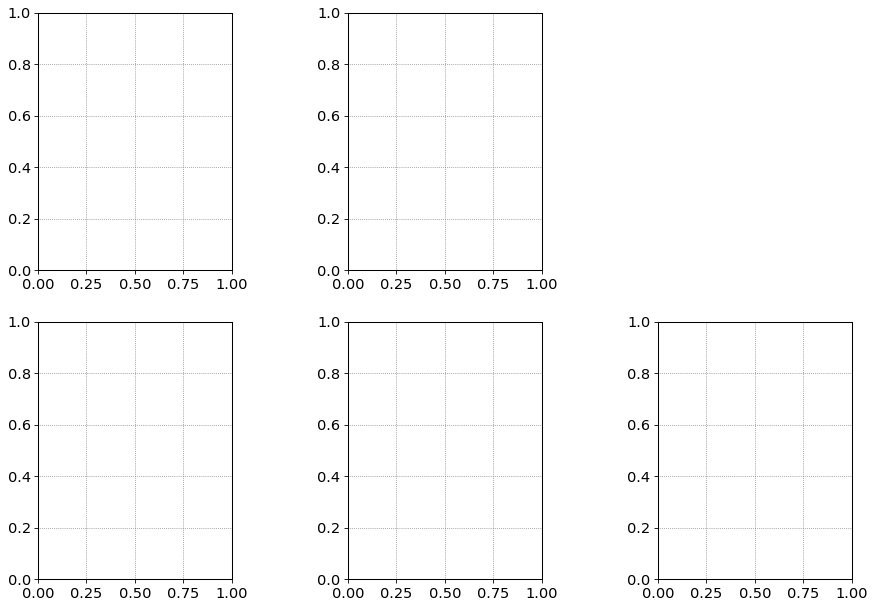

In [6]:
fig = plt.figure(figsize=(14,10))
gs = GridSpec(2,
              3,
              wspace=0.6,
              hspace=0.2,
             )

ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1])
ax12 = fig.add_subplot(gs[1,2])


# prepare spatial coordinate vectors
nx = eps.shape[0]
ny = eps.shape[1]
x = Wgrid * np.linspace(-1/2., 1/2., nx)
y = Hgrid * np.linspace(-1/2., 1/2., ny)

# plot index as a function of space
p00 = ax00.pcolormesh(x,y,np.sqrt(eps.T),label='index')

# plot binary variable detecting core material
p01 = ax01.pcolormesh(x,y,isAlOx.T,cmap=cm.Greys,label='isAlOx')

# plot Ex, Ey and ϵ|E|^2 
vmax = e.real.max()
vmin = e.real.min()

axind = 0 
p10 = ax10.pcolormesh(x,
                      y,
                      e[:,:,0,axind].T.real,
                      cmap=cm.RdBu,
                      vmin=vmin,
                      vmax=vmax,
                     )

axind = 1 
p11 = ax11.pcolormesh(x,
                      y,
                      e[:,:,0,axind].T.real,
                      cmap=cm.RdBu,
                      vmin=vmin,
                      vmax=vmax,
                     )

axind = 0
p12 = ax12.pcolormesh(x,y,eps_ei2[:,:,axind].T,cmap=cm.magma)



## format and label plots

ax = [ax00,ax01,ax10,ax11,ax12]
p = [p00,p01,p10,p11,p12]
labels = ['index',
          'isAlOx',
          'E$_{x}$',
          'E$_{y}$',
          'ϵ|E$_x$|$^2$',
         ]




for aind,a in enumerate(ax):
    a.set_aspect('equal')
    a.set_xlabel('x [μm]')
    a.set_ylabel('y [μm]')
    divider = make_axes_locatable(a)
    cax = divider.append_axes("top", size="5%", pad=0.05)
    cb = plt.colorbar(p[aind],
                 cax=cax,
                 orientation="horizontal",
                )
    cb.set_label(labels[aind])#,labelpad=-1)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')

# AD attempts

In [57]:
# define new parameters for angled sidewalls, partial etch, conformal deposited layers after wg etch,

θ = 0. # sidewall angle in degrees, 0 = vertical
w_top = 0.8*u.um #0.2*u.um # top width of partially etched "core layer" in microns
t_core = 0.5*u.um # full thickness of "core layer" in microns
t_etch = 0.5*u.um #0.15 # etch depth into "core layer" in microns
t_ald = .05*u.um
lam = 0.85*u.um # free space wavelength in microns
dx_base = np.tan(np.deg2rad(θ)) * t_etch
n_points = 2
mat_core = 'Alumina'
mat_clad = 'SiO2'
Xgrid = 6
Ygrid = 6
n_modes = 8
res = 32
do_func = None

res_dr = res/2
Δx_dr = 1.
Δy_dr = 0.35

In [58]:
# initalize modesolver, design region and optimization problem objects

# compute a few more useful quantities with user parameters
nx = Xgrid * res
ny = Ygrid * res
nz = 1

x = Xgrid * np.linspace(-1/2., 1/2., nx)
y = Ygrid * np.linspace(-1/2., 1/2., ny)

k_points = [mp.Vector3(0, 0, 2.8),]
# k_points = mp.interpolate(n_points, [mp.Vector3(0.05, 0, 0), mp.Vector3(0.05*n_points, 0, 0)])
#get_wgparams(w_top,θ,t_core,t_etch,lam,mat_core,mat_clad,Xgrid,Ygrid,n_points,n_bands=4,res=32,do_func=None,)

w_top = w_top.to(u.um).m
t_core = t_core.to(u.um).m
t_etch = t_etch.to(u.um).m
lam = lam.to(u.um).m
ω = 1/lam # frequency in units of c

# get phase and group indices for these materials at this wavelength
n_core =  get_index(mat_core, lam); ng_core =  get_ng(mat_core, lam)
n_clad =  get_index(mat_clad, lam); ng_clad = get_ng(mat_clad, lam)
med_core = mp.Medium(index=n_core); med_clad = mp.Medium(index=n_clad)

# configure and initialize design region


design_region = mp.Volume(center=mp.Vector3((w_top+Δx_dr)/2.,Δy_dr/2. + (t_core-t_etch),0),
                          size=mp.Vector3(Δx_dr, Δy_dr, 0),
                         )
design_variables = mpa.BilinearInterpolationBasis(volume=design_region,
                                                  resolution=res_dr,
                                                 )

Nx = design_variables.Nx # number of parameters in the x direction
Ny = design_variables.Ny # number of parameters in the y direction
x0 = (n_core**2 - n_clad**2)*np.random.rand(Nx*Ny) + n_clad**2
design_variables.set_rho_vector(x0)

# center=mp.Vector3((w_top+Δx_dr)/2.,Δy_dr/2.)
# func = design_variables.func()
# func(center+mp.Vector3(0.02,0.3))

# define geometry with design region

lat = mp.Lattice(size=mp.Vector3(Xgrid, Ygrid,0))
dx_base = np.tan(np.deg2rad(θ)) * t_etch
verts_core = [mp.Vector3(-w_top/2.,t_core),
        mp.Vector3(w_top/2.,t_core),
        mp.Vector3(w_top/2+dx_base,t_core-t_etch),
        mp.Vector3(-w_top/2-dx_base,t_core-t_etch),
       ]
core = mp.Prism(verts_core, height=mp.inf, material=med_core)
if t_etch<t_core:   # partial etch
    slab = mp.Block(size=mp.Vector3(mp.inf, t_core-t_etch , mp.inf), center=mp.Vector3(0, (t_core-t_etch), 0),material=med_core)
    geom = [core,
            slab,
            mp.Block(center=design_region.center,               # design region
                     size=design_region.size,
                     epsilon_func=design_variables.func(),
                    ) 
            ]
    # print('adding slab block')
else:
    geom = [core,
            mp.Block(center=design_region.center,                # design region
                     size=design_region.size,
                     epsilon_func=design_variables.func(),
                    ) 
           ]


# instantiate ModeSolver and solve for a few modes


# TE0 = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(0,1,0),size=mp.Vector3(x=2)),mode=1)
# ob_list = [TE0]

# TE0 = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(0,1,0),size=mp.Vector3(x=2)),mode=1)

ob_list = [4,]

blackhole = StringIO()
with pipes(stdout=blackhole, stderr=STDOUT):
    ms = mpb.ModeSolver(geometry_lattice=lat,
                        geometry=[],
                        k_points=k_points,
                        resolution=res,
                        num_bands=n_modes,
                        default_material=med_clad)
    ms.geometry = geom
    ms.default_material = med_clad
    ms.init_params(mp.NO_PARITY, False)
#     eps = np.array(ms.get_epsilon())

def get_fieldprops(ms, band):
    mpb.fix_efield_phase(ms,band)
    e = np.array(ms.get_efield(band))
    eps_ei2 = eps.reshape(eps.shape+(1,)) * np.abs(e[:, :, 0, :]**2)
    ei_pwr = eps_ei2.sum(axis=(0, 1))
    if (ei_pwr[0] > ei_pwr[1]):
        print ("TE mode!\n")
        out['pol'][band-1] = 'TE'
    else:
        print ("TM mode!\n")
        out['pol'][band-1] = 'TM'
    # Calculate eps |E|^2.  Then get power in the core material, and distribution along x.
    # Get n_g.  Adjust by material disperision factor (n_{g,mat}/n_{mat}), weighted by eps |E|^2 above.
    epwr = eps_ei2.sum(-1) / eps_ei2.sum()
    p_mat_core_x = (epwr * mat_core_mask).sum(-1)
    p_mat_core = p_mat_core_x.sum()
    ng_nodisp = 1 / ms.compute_one_group_velocity_component(mp.Vector3(0, 0, 1), band)
    ng = ng_nodisp * (p_mat_core * (ng_core / n_core) + (1 - p_mat_core) * (ng_clad / n_clad))

    # Output various stuff.
    out['band'][band-1] = band
    out['ng'][band-1] = ng
    out['ng_nodisp'][band-1] = ng_nodisp
    out['p_mat_core'][band-1] = p_mat_core
    out['p_mat_core_x'][...,band-1] = p_mat_core_x
    out['E'][...,band-1] = e
    out['H'][...,band-1] = np.array(ms.get_hfield(band))
    out['D'][...,band-1] = np.array(ms.get_dfield(band))
    if (do_func != None):
        do_func(out, ms, band)

# def J(x):
#     return x

def Ja(a,b):
    return a

def Jb(a,b):
    return b

opt = OptimizationProblem(modesolver=ms,
                        objective_functions=[Ja,Jb], #J,
                        objective_arguments=ob_list,
                        design_variables=[design_variables],
                        )

Working in 2 dimensions.
Grid size is 192 x 192 x 1.
Solving for 8 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (6, 0, 0)
     (0, 6, 0)
     (0, 0, 1)
Cell volume = 36
Reciprocal lattice vectors (/ 2 pi):
     (0.166667, -0, 0)
     (-0, 0.166667, -0)
     (0, -0, 1)
Geometric objects:
     prism, center = (0,0.25,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.4,0.5,0)
          (0.4,0.5,0)
          (0.4,0,0)
          (-0.4,0,0)
     block, center = (0.9,0.175,0)
          size (1,0.35,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...
epsilon: 2.10987-2.61735, mean 2.11835, harm. mean 2.11697, 100% > 1, 1.67134% "fill"


In [59]:
opt.solve()

Working in 2 dimensions.
Grid size is 192 x 192 x 1.
Solving for 8 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (6, 0, 0)
     (0, 6, 0)
     (0, 0, 1)
Cell volume = 36
Reciprocal lattice vectors (/ 2 pi):
     (0.166667, -0, 0)
     (-0, 0.166667, -0)
     (0, -0, 1)
Geometric objects:
     prism, center = (0,0.25,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.4,0.5,0)
          (0.4,0.5,0)
          (0.4,0,0)
          (-0.4,0,0)
     block, center = (0.9,0.175,0)
          size (1,0.35,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Solving for band polarization: .
Initializing eigensolver data
Computing 8 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 192 x 192 x 1.
Solving for 8 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (6, 0, 0)
     (0,

D-energy-components:, 1, 5, 0.954688, 0.00397897, 0.0413327
B-energy-components:, 1, 5, 0.00495219, 0.968393, 0.0266552
D-energy-components:, 1, 6, 0.00447998, 0.966993, 0.0285272
B-energy-components:, 1, 6, 0.959648, 0.00316018, 0.0371917
D-energy-components:, 1, 7, 0.983792, 0.00179993, 0.0144082
B-energy-components:, 1, 7, 0.00270641, 0.930067, 0.0672262
D-energy-components:, 1, 8, 0.00823742, 0.933321, 0.0584419
B-energy-components:, 1, 8, 0.980161, 0.00687241, 0.0129668


std(err):
0.0861121606651955
mean(abs((err)):
0.06664473901403625


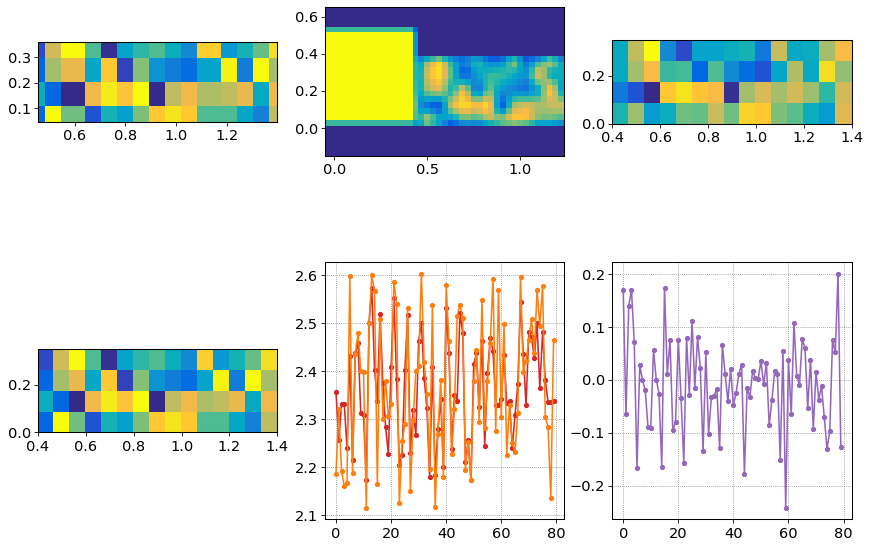

In [56]:
# from mpb_adj import Grid

dr = opt.design_regions[0]

dr.get_edges()

dr_mask = np.zeros(opt.shape)
for xind,xx in enumerate(opt.x):
    for yind,yy in enumerate(opt.y):
#         for zind,zz in opt.z:
        dr_mask[xind,yind] = dr.pt_in_volume(mp.Vector3(xx,yy))

xinds_dr,yinds_dr = np.where(dr_mask)


dv = opt.design_variables[0]

dv.Nx # 32
dv.Ny # 11
dv.rho_vector.shape # 352
xinds_dr.shape

self = opt
offs= 1

def find_idx(dv):
    xind = np.zeros(dv.Nx,dtype='int')
    yind = np.zeros(dv.Ny,dtype='int')
    for xind_dr,xx_dr in enumerate(dv.rho_x):
        xx_dr_eff =  xx_dr 
        if xind_dr + 1 == len(dv.rho_x):
            xind[xind_dr] = int(np.argmin(np.abs(self.x-xx_dr_eff))) 
        elif xind_dr == 0:
            xind[xind_dr] = int(np.argmin(np.abs(self.x-xx_dr_eff))) + 2
        else:
            xind[xind_dr] = int(np.argmin(np.abs(self.x-xx_dr_eff))) + 1
        
    for yind_dr,yy_dr in enumerate(dv.rho_y):
        yy_dr_eff = yy_dr 
        if yind_dr + 1 == len(dv.rho_y):
            yind[yind_dr] = int(np.argmin(np.abs(self.y-yy_dr_eff))) 
        elif yind_dr == 0:
            yind[yind_dr] = int(np.argmin(np.abs(self.y-yy_dr_eff))) + 2
        else:
            yind[yind_dr] = int(np.argmin(np.abs(self.y-yy_dr_eff))) + 1
    return xind,yind

xind,yind = find_idx(dv)

fig,ax = plt.subplots(2,3,figsize=(14,10))

xlim = -0.05,1.24
ylim = -0.15,.65

ax[0,0].pcolormesh(opt.x[xind],opt.y[yind],dv.rho_vector.reshape((dv.Nx,dv.Ny)).T)

# ax[1].pcolormesh(opt.x[xind],opt.y[yind],opt.epsilon[xind,yind].T)
ax[0,1].pcolormesh(opt.x,opt.y,opt.epsilon.T,vmin=dv.rho_vector.min(),vmax=dv.rho_vector.max())
ax[0,1].set_xlim(xlim)
ax[0,1].set_ylim(ylim)

indexing = 'ij'

xind_vec,yind_vec = np.meshgrid(xind,yind,indexing=indexing)
# xind_vec = xind_vec.T.flatten() + 1
# yind_vec = yind_vec.T.flatten() + 1

xind_vec = xind_vec.flatten() 
yind_vec = yind_vec.flatten() 

x_vec = self.x[xind_vec]
y_vec = self.y[xind_vec]

eps_dr = opt.epsilon[xind_vec,yind_vec]
# ax[0,2].pcolormesh(dv.rho_x,dv.rho_y,eps_dr.reshape((dv.Nx,dv.Ny)))

# ax[1,0].plot(dv.rho_vector,'oC0')


# dv.rho_x
# opt.epsilon[xind_vec,yind_vec]

# ax[1,0].plot(,'o')

rho_X, rho_Y = np.meshgrid(dv.rho_x,dv.rho_y,indexing=indexing)


ax[0,2].pcolormesh(rho_X,rho_Y,eps_dr.reshape((dv.Nx,dv.Ny)))
ax[1,0].pcolormesh(rho_X,rho_Y,dv.rho_vector.reshape((dv.Nx,dv.Ny)))


for a in [ax[0,0],ax[0,1],ax[0,2],ax[1,0]]:
    a.set_aspect('equal')

i_max = 300


# ax[1,0].plot(self.x[xind_vec[:i_max]],'.C3')
# ax[1,0].plot(dv.rho_x[:i_max],'.C1')
# ax[1,1].plot(self.y[yind_vec[:i_max]],'.C0')
# ax[1,1].plot(dv.rho_y[:i_max],'.C2')


# ax[0,0].plot(self.x[xind_vec[:i_max]],
#              self.y[yind_vec[:i_max]],
#              '.C3',
#             )
# ax[0,0].plot(rho_X.flatten()[:i_max],
#              rho_Y.flatten()[:i_max],
#              '.C1',
#             )

# ax[0,1].plot(self.x[xind_vec[:i_max]],
#              self.y[yind_vec[:i_max]],
#              '.C3',
#             )
# ax[0,1].plot(rho_X.flatten()[:i_max],
#              rho_Y.flatten()[:i_max],
#              '.C1',
#             )


ax[1,1].plot(eps_dr[:i_max],
             '.-C3',
            )
ax[1,1].plot(dv.rho_vector[:i_max],
             '.-C1',
            )

ax[1,2].plot(eps_dr[:i_max]-dv.rho_vector[:i_max],
             '.-C4',
            )

print('std(err):')
print(np.std(eps_dr-dv.rho_vector))

print('mean(abs((err)):')
print(np.mean(np.abs(eps_dr-dv.rho_vector)))

# ax[1,0].plot(eps_dr[:i_max],'.C3')
# ax[1,0].plot(dv.rho_vector[:i_max],'.C0')
# ax[1,0].plot(dv.rho_vector/eps_dr,'.C3')

# ax[1,0].set_ylim([-0.1,1.5])

In [12]:
# Autodiff-compatible functions for use inside 2D MPB solver

import autograd.numpy as npa
from autograd import grad, jacobian

def curl_2D(V,x,y,kz,a=1):
    """
    Calculate and return the curl of the 2D 3-vector field V(x,y) = [Vx(x,y),Vy(x,y),Vz(x,y)]
    for MPB scaled spatial coordiantes x and y with scaling factor a (= 1/(2*kz) ?)
    and an assumed spatial period along z of kz
    """
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    dVx_dx = npa.gradient(V[:,:,0],axis=0) / ( dx / a )
    dVy_dx = npa.gradient(V[:,:,1],axis=0) / ( dx / a )
    dVz_dx = npa.gradient(V[:,:,2],axis=0) / ( dx / a )
    dVx_dy = npa.gradient(V[:,:,0],axis=1) / ( dy / a )
    dVy_dy = npa.gradient(V[:,:,1],axis=1) / ( dy / a )
    dVz_dy = npa.gradient(V[:,:,2],axis=1) / ( dy / a )

    curl_V = npa.stack([dVz_dy - 1j * kz * V[:,:,1],
                       1j * kz * V[:,:,0] - dVz_dx,
                       dVy_dx - dVx_dy,
                      ],
                      axis=-1)
    return curl_V

def D_2D(H,ω,x,y,kz,a=1):
    return (1j / ω) *  curl_2D(H,x,y,kz,a=a)

def E_2D(H,ω,eps,x,y,kz,a=1):
    return (1j / ω) *  curl_2D(H,x,y,kz,a=a) / npa.reshape(eps,npa.shape(eps)+(1,))

def S_2D(H,ω,eps,x,y,kz,a=1):
    return npa.cross(npa.conjugate(E_2D(H,ω,eps,x,y,kz,a=a)),H)

def U_2D(H,ω,eps,x,y,kz,a=1):
    eps_rs = npa.reshape(eps,npa.shape(eps)+(1,))
    return npa.sum(eps_rs*npa.abs(E_2D(H,ω,eps,x,y,kz,a=a))**2+npa.abs(H)**2,axis=2)

def ng_2D(H,ω,eps,x,y,kz,a=1):
    return 0.5 / ( npa.sum(npa.real(S_2D(H,ω,eps,x,y,kz,a=a)[:,:,2]),axis=(0,1)) / npa.sum(U_2D(H,ω,eps,x,y,kz,a=a),axis=(0,1)) )

grad_ng_2D = grad(ng_2D,(0,1,2))

In [70]:
self = opt
self.grad_H = np.squeeze(np.zeros_like(self.H))
self.grad_ω = np.zeros_like(self.ω)
self.grad_eps_ng = np.zeros((self.Nx,self.Ny,self.n_modes))
for band_ind in range(self.n_modes):
    grad_H_temp, grad_ω_temp, grad_eps_temp = grad_ng_2D(self.H[:,:,0,:,band_ind],
                                                                self.ω[band_ind],
                                                                self.epsilon,
                                                                self.x,
                                                                self.y,
                                                                self.k_points[0],
                                                                a=( 1 / self.k_points[0] / 2 ), # TODO: figure out what/why this value of "a" works
                                                                )
    self.grad_H[:,:,:,band_ind] = grad_H_temp
    self.grad_ω[band_ind] = grad_ω_temp
    self.grad_eps_ng[:,:,band_ind] = grad_eps_temp  #np.sum(grad_eps_temp,axis=-1)

self.grad_eps_ng_eigs = np.zeros(self.epsilon.shape + (3,),dtype='complex128')
for j in range(self.n_modes):
    if j==self.tracked_mode_ind:
        self.grad_eps_ng_eigs += np.abs(self.E[:,:,0,:,j])**2 * ( 2 * self.grad_ω[j] )
    else:
        scale = np.sum(np.conjugate(self.H[:,:,0,:,j])*self.grad_H[...,j]) / ( self.ω[j]**2 - self.ω[self.tracked_mode_ind]**2 ) * self.dx * self.dy
        self.grad_eps_ng_eigs += (np.conjugate(self.E[:,:,0,:,j]) * self.E[:,:,0,:,self.tracked_mode_ind] ) * scale

E_dr = self.E[self.design_region_inds_vec[0][0],self.design_region_inds_vec[0][1],0,:,:]
grad_eps_ω_sq_dr = np.sum(np.abs(E_dr)**2,axis=-2) # sum contributions of independent E-field components (ax=-1 is modes
grad_eps_ng_dr = self.grad_eps_ng[self.design_region_inds_vec[0][0],self.design_region_inds_vec[0][1]]
grad_eps_ng_eigs_dr = self.grad_eps_ng_eigs[self.design_region_inds_vec[0][0],self.design_region_inds_vec[0][1]]
self.gradient = [grad_eps_ω_sq_dr,grad_eps_ng_dr,grad_eps_ng_eigs_dr]

#opt.calculate_gradient()

#grad_ng = self.gradient[1][:,0] + opt.gradient[2].sum(axis=1)

In [19]:
# grad_eps_ng_eigs_dr.shape

# grad_eps_dr = self.gradient[1][:,0] + opt.gradient[2].sum(axis=1)

grad_eps_dr.shape

(352,)

In [63]:
db = 1e-3
choose = 20
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)

Working in 2 dimensions.
Grid size is 192 x 192 x 1.
Solving for 8 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (6, 0, 0)
     (0, 6, 0)
     (0, 0, 1)
Cell volume = 36
Reciprocal lattice vectors (/ 2 pi):
     (0.166667, -0, 0)
     (-0, 0.166667, -0)
     (0, -0, 1)
Geometric objects:
     prism, center = (0,0.25,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.4,0.5,0)
          (0.4,0.5,0)
          (0.4,0,0)
          (-0.4,0,0)
     block, center = (0.9,0.175,0)
          size (1,0.35,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Solving for band polarization: .
Initializing eigensolver data
Computing 8 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 192 x 192 x 1.
Solving for 8 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (6, 0, 0)
     (0,

Geometric object tree has depth 1 and 2 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Solving for band polarization: .
Initializing eigensolver data
Computing 8 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 192 x 192 x 1.
Solving for 8 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (6, 0, 0)
     (0, 6, 0)
     (0, 0, 1)
Cell volume = 36
Reciprocal lattice vectors (/ 2 pi):
     (0.166667, -0, 0)
     (-0, 0.166667, -0)
     (0, -0, 1)
Geometric objects:
     prism, center = (0,0.25,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.4,0.5,0)
          (0.4,0.5,0)
          (0.4,0,0)
          (-0.4,0,0)
     block, center = (0.9,0.175,0)
          size (1,0.35,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Solving for band polarization: .
Initializing fields to 

          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Solving for band polarization: .
Initializing fields to random numbers...
1 k-points
  Vector3<0.0, 0.0, 2.8>
elapsed time for initialization: 0.21061420440673828
solve_kpoint (0,0,2.8):
freqs:, k index, k1, k2, k3, kmag/2pi, band 1, band 2, band 3, band 4, band 5, band 6, band 7, band 8
Solving for bands 1 to 8...
    iteration    2: trace = 39.71431851050551 (62.9646% change)
    iteration    4: trace = 31.8175681583023 (6.60429% change)
    iteration    6: trace = 29.66440189972935 (2.89555% change)
    iteration    8: trace = 28.75142246683152 (1.21448% change)
    iteration   10: trace = 28.37908578501427 (0.53055% change)
    iteration   12: trace = 28.17539560691352 (0.319347% change)
    iteration   14: trace = 28.05918455441523 (0.171377% change)
    iteration   15: trace = 28.02618634949803 (0.117671% change)
    iteration   17:

    iteration    2: trace = 39.60599990104684 (63.1598% change)
    iteration    4: trace = 31.83667680857455 (6.3472% change)
    iteration    6: trace = 29.70478291402387 (2.98644% change)
    iteration    8: trace = 28.75592331845933 (1.24535% change)
    iteration   10: trace = 28.31931404069456 (0.66894% change)
    iteration   12: trace = 28.10378980847225 (0.286607% change)
    iteration   14: trace = 28.03176062716975 (0.0957684% change)
    iteration   16: trace = 27.99837997391882 (0.0525376% change)
    iteration   18: trace = 27.97380072952118 (0.0428392% change)
    iteration   20: trace = 27.94948259830898 (0.0434835% change)
    iteration   22: trace = 27.92735256632191 (0.0376822% change)
    iteration   24: trace = 27.91045508140352 (0.0275374% change)
    iteration   26: trace = 27.89933219970282 (0.0177527% change)
    iteration   28: trace = 27.8919050814587 (0.0121463% change)
    iteration   30: trace = 27.88709782906336 (0.00734066% change)
    iteration   32: tr

    iteration   30: trace = 27.89001473496153 (0.00683635% change)
    iteration   32: trace = 27.88720337884597 (0.00461288% change)
    iteration   34: trace = 27.88514583208286 (0.00337509% change)
    iteration   36: trace = 27.88380191824159 (0.00209943% change)
    iteration   38: trace = 27.88299869946889 (0.00126227% change)
    iteration   40: trace = 27.88254640122302 (0.000674171% change)
    iteration   42: trace = 27.88232203344654 (0.000328643% change)
    iteration   44: trace = 27.88221395325865 (0.000159717% change)
    iteration   46: trace = 27.88215716694289 (9.04235e-05% change)
    iteration   48: trace = 27.88212246397446 (5.38754e-05% change)
    iteration   50: trace = 27.88210179497585 (3.19395e-05% change)
    iteration   52: trace = 27.88208968812153 (1.87612e-05% change)
    iteration   54: trace = 27.8820829906278 (9.85054e-06% change)
Finished solving for bands 1 to 8 after 54 iterations.
freqs:, 1, 0, 0, 2.8, 2.8, 1.80076, 1.80451, 1.85724, 1.85986, 1.88

    iteration   54: trace = 27.88195999865701 (9.35095e-06% change)
Finished solving for bands 1 to 8 after 54 iterations.
freqs:, 1, 0, 0, 2.8, 2.8, 1.80076, 1.80451, 1.85723, 1.85985, 1.88666, 1.88951, 1.91476, 1.91796
elapsed time for k point: 13.60123348236084
Fixing e-field (band 1) phase by 0.608439 + 0.793601i; max ampl. = 1.31245
Fixing e-field (band 2) phase by 0.355071 + -0.934839i; max ampl. = 1.29421
Fixing e-field (band 3) phase by -0.283022 + -0.959113i; max ampl. = 1.09868
Fixing e-field (band 4) phase by -0.487351 + 0.873206i; max ampl. = 1.10892
Fixing e-field (band 5) phase by 0.29066 + -0.956826i; max ampl. = 1.19124
Fixing e-field (band 6) phase by 0.954182 + -0.299227i; max ampl. = 1.16861
Fixing e-field (band 7) phase by 0.322228 + 0.946662i; max ampl. = 1.09237
Fixing e-field (band 8) phase by 0.695976 + 0.718065i; max ampl. = 0.934247
Outputting fields to e.k01.b01.h5...
Outputting fields to e.k01.b02.h5...
Outputting fields to e.k01.b03.h5...
Outputting fields 

Fixing e-field (band 7) phase by -0.985387 + 0.170331i; max ampl. = 1.09207
Fixing e-field (band 8) phase by 0.195122 + 0.980779i; max ampl. = 0.93372
Outputting fields to e.k01.b01.h5...
Outputting fields to e.k01.b02.h5...
Outputting fields to e.k01.b03.h5...
Outputting fields to e.k01.b04.h5...
Outputting fields to e.k01.b05.h5...
Outputting fields to e.k01.b06.h5...
Outputting fields to e.k01.b07.h5...
Outputting fields to e.k01.b08.h5...
Outputting fields to h.k01.b01.h5...
Outputting fields to h.k01.b02.h5...
Outputting fields to h.k01.b03.h5...
Outputting fields to h.k01.b04.h5...
Outputting fields to h.k01.b05.h5...
Outputting fields to h.k01.b06.h5...
Outputting fields to h.k01.b07.h5...
Outputting fields to h.k01.b08.h5...
D-energy-components:, 1, 1, 0.981139, 0.000682176, 0.018179
Outputting dpwr.k01.b01.h5...
D-energy-components:, 1, 2, 0.000897754, 0.962472, 0.03663
Outputting dpwr.k01.b02.h5...
D-energy-components:, 1, 3, 0.948682, 0.00880981, 0.0425082
Outputting dpwr.k0

Outputting fields to e.k01.b08.h5...
Outputting fields to h.k01.b01.h5...
Outputting fields to h.k01.b02.h5...
Outputting fields to h.k01.b03.h5...
Outputting fields to h.k01.b04.h5...
Outputting fields to h.k01.b05.h5...
Outputting fields to h.k01.b06.h5...
Outputting fields to h.k01.b07.h5...
Outputting fields to h.k01.b08.h5...
D-energy-components:, 1, 1, 0.981137, 0.000682419, 0.0181801
Outputting dpwr.k01.b01.h5...
D-energy-components:, 1, 2, 0.00089713, 0.962471, 0.0366318
Outputting dpwr.k01.b02.h5...
D-energy-components:, 1, 3, 0.948675, 0.00881616, 0.0425091
Outputting dpwr.k01.b03.h5...
D-energy-components:, 1, 4, 0.00986472, 0.958309, 0.0318264
Outputting dpwr.k01.b04.h5...
D-energy-components:, 1, 5, 0.954688, 0.00398263, 0.0413296
Outputting dpwr.k01.b05.h5...
D-energy-components:, 1, 6, 0.00447768, 0.966996, 0.0285268
Outputting dpwr.k01.b06.h5...
D-energy-components:, 1, 7, 0.983767, 0.00183442, 0.0143989
Outputting dpwr.k01.b07.h5...
D-energy-components:, 1, 8, 0.008792

D-energy-components:, 1, 3, 0.94868, 0.00881737, 0.0425024
Outputting dpwr.k01.b03.h5...
D-energy-components:, 1, 4, 0.00987031, 0.958308, 0.031822
Outputting dpwr.k01.b04.h5...
D-energy-components:, 1, 5, 0.95469, 0.00397334, 0.0413365
Outputting dpwr.k01.b05.h5...
D-energy-components:, 1, 6, 0.00447519, 0.966989, 0.0285354
Outputting dpwr.k01.b06.h5...
D-energy-components:, 1, 7, 0.98375, 0.00186209, 0.0143884
Outputting dpwr.k01.b07.h5...
D-energy-components:, 1, 8, 0.00877816, 0.932744, 0.0584775
Outputting dpwr.k01.b08.h5...
Outputting fields to flux.v.k01.b01.h5...
Outputting fields to flux.v.k01.b02.h5...
Outputting fields to flux.v.k01.b03.h5...
Outputting fields to flux.v.k01.b04.h5...
Outputting fields to flux.v.k01.b05.h5...
Outputting fields to flux.v.k01.b06.h5...
Outputting fields to flux.v.k01.b07.h5...
Outputting fields to flux.v.k01.b08.h5...
D-energy-components:, 1, 1, 0.981139, 0.000682611, 0.0181782
B-energy-components:, 1, 1, 0.000728381, 0.967088, 0.0321837
Output

D-energy-components:, 1, 1, 0.981142, 0.000682149, 0.0181758
B-energy-components:, 1, 1, 0.000728437, 0.967088, 0.032184
Outputting tot.rpwr.k01.b01.h5...
D-energy-components:, 1, 2, 0.000898559, 0.962471, 0.0366308
B-energy-components:, 1, 2, 0.982717, 0.000578749, 0.0167046
Outputting tot.rpwr.k01.b02.h5...
D-energy-components:, 1, 3, 0.948691, 0.00880986, 0.042499
B-energy-components:, 1, 3, 0.00990746, 0.961311, 0.0287814
Outputting tot.rpwr.k01.b03.h5...
D-energy-components:, 1, 4, 0.00986068, 0.958314, 0.0318254
B-energy-components:, 1, 4, 0.947834, 0.00824465, 0.0439214
Outputting tot.rpwr.k01.b04.h5...
D-energy-components:, 1, 5, 0.954661, 0.00398941, 0.0413499
B-energy-components:, 1, 5, 0.00496195, 0.968376, 0.0266621
Outputting tot.rpwr.k01.b05.h5...
D-energy-components:, 1, 6, 0.00448192, 0.966992, 0.0285264
B-energy-components:, 1, 6, 0.959687, 0.00316708, 0.0371459
Outputting tot.rpwr.k01.b06.h5...
D-energy-components:, 1, 7, 0.983772, 0.00182975, 0.0143987
B-energy-compo

D-energy-components:, 1, 5, 0.954678, 0.003983, 0.041339
B-energy-components:, 1, 5, 0.00495519, 0.968387, 0.026658
Outputting tot.rpwr.k01.b05.h5...
D-energy-components:, 1, 6, 0.00448454, 0.966998, 0.0285174
B-energy-components:, 1, 6, 0.959698, 0.00316591, 0.0371359
Outputting tot.rpwr.k01.b06.h5...
D-energy-components:, 1, 7, 0.983793, 0.00178672, 0.0144204
B-energy-components:, 1, 7, 0.0027006, 0.930108, 0.067191
Outputting tot.rpwr.k01.b07.h5...
D-energy-components:, 1, 8, 0.00764728, 0.933878, 0.0584748
B-energy-components:, 1, 8, 0.980785, 0.00627303, 0.0129424
Outputting tot.rpwr.k01.b08.h5...
total elapsed time for run: 20.03380012512207
done
Working in 2 dimensions.
Grid size is 192 x 192 x 1.
Solving for 8 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (6, 0, 0)
     (0, 6, 0)
     (0, 0, 1)
Cell volume = 36
Reciprocal lattice vectors (/ 2 pi):
     (0.166667, -0, 0)
     (-0, 0.166667, -0)
     (0, -0, 1)
Geometric objects:
     prism, cent

          (-0.4,0.5,0)
          (0.4,0.5,0)
          (0.4,0,0)
          (-0.4,0,0)
     block, center = (0.9,0.175,0)
          size (1,0.35,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Solving for band polarization: .
Initializing eigensolver data
Computing 8 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 192 x 192 x 1.
Solving for 8 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (6, 0, 0)
     (0, 6, 0)
     (0, 0, 1)
Cell volume = 36
Reciprocal lattice vectors (/ 2 pi):
     (0.166667, -0, 0)
     (-0, 0.166667, -0)
     (0, -0, 1)
Geometric objects:
     prism, center = (0,0.25,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.4,0.5,0)
          (0.4,0.5,0)
          (0.4,0,0)
          (-0.4,0,0)
     block, center = (0.9,0.175,0)
          size (1,0.35,0)
          axes (1,

     (-0, 0.166667, -0)
     (0, -0, 1)
Geometric objects:
     prism, center = (0,0.25,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.4,0.5,0)
          (0.4,0.5,0)
          (0.4,0,0)
          (-0.4,0,0)
     block, center = (0.9,0.175,0)
          size (1,0.35,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Solving for band polarization: .
Initializing fields to random numbers...
1 k-points
  Vector3<0.0, 0.0, 2.8>
elapsed time for initialization: 0.21564173698425293
solve_kpoint (0,0,2.8):
freqs:, k index, k1, k2, k3, kmag/2pi, band 1, band 2, band 3, band 4, band 5, band 6, band 7, band 8
Solving for bands 1 to 8...
    iteration    2: trace = 39.67197368156444 (63.2189% change)
    iteration    4: trace = 31.87673326959405 (6.45132% change)
    iteration    6: trace = 29.76334418323943 (2.86881% change)
    iteration    8: tr

1 k-points
  Vector3<0.0, 0.0, 2.8>
elapsed time for initialization: 0.21439862251281738
solve_kpoint (0,0,2.8):
freqs:, k index, k1, k2, k3, kmag/2pi, band 1, band 2, band 3, band 4, band 5, band 6, band 7, band 8
Solving for bands 1 to 8...
    iteration    2: trace = 39.66947644606043 (63.1372% change)
    iteration    4: trace = 31.74567729775147 (6.6621% change)
    iteration    6: trace = 29.56705572700104 (2.88299% change)
    iteration    8: trace = 28.71619467461532 (1.14854% change)
    iteration   10: trace = 28.31290877468296 (0.597666% change)
    iteration   12: trace = 28.11885569425768 (0.275747% change)
    iteration   14: trace = 28.03030171992052 (0.128393% change)
    iteration   16: trace = 27.988941837899 (0.0597188% change)
    iteration   18: trace = 27.96843902825695 (0.0319865% change)
    iteration   20: trace = 27.95320834368639 (0.0263969% change)
    iteration   22: trace = 27.94054071170795 (0.0211979% change)
    iteration   24: trace = 27.93054241728283

    iteration   18: trace = 27.96765134623245 (0.0371421% change)
    iteration   20: trace = 27.95041069242938 (0.0301691% change)
    iteration   22: trace = 27.93229726484435 (0.0333935% change)
    iteration   24: trace = 27.91370469882518 (0.0322732% change)
    iteration   26: trace = 27.90044453747739 (0.0208218% change)
    iteration   28: trace = 27.89207986724785 (0.0134404% change)
    iteration   30: trace = 27.88700682810633 (0.00762666% change)
    iteration   32: trace = 27.88448787634751 (0.00375496% change)
    iteration   34: trace = 27.88319678878073 (0.00193178% change)
    iteration   36: trace = 27.88253966774665 (0.000985937% change)
    iteration   38: trace = 27.88218414896703 (0.00055176% change)
    iteration   40: trace = 27.88198310821387 (0.000305873% change)
    iteration   42: trace = 27.8818800331875 (0.000149637% change)
    iteration   44: trace = 27.88183315819069 (6.69504e-05% change)
    iteration   46: trace = 27.88181152125537 (3.34875e-05% chang

    iteration   46: trace = 27.88193965105036 (0.000167507% change)
    iteration   48: trace = 27.88187752591016 (9.56525e-05% change)
    iteration   50: trace = 27.88184302548004 (5.22452e-05% change)
    iteration   52: trace = 27.88182280152803 (3.24056e-05% change)
    iteration   54: trace = 27.88180963034815 (2.05576e-05% change)
    iteration   56: trace = 27.88180260363232 (1.02777e-05% change)
Finished solving for bands 1 to 8 after 57 iterations.
freqs:, 1, 0, 0, 2.8, 2.8, 1.80076, 1.80451, 1.85723, 1.85985, 1.88664, 1.8895, 1.91476, 1.91795
elapsed time for k point: 14.627550601959229
Fixing e-field (band 1) phase by -0.886871 + -0.462016i; max ampl. = 1.31245
Fixing e-field (band 2) phase by -0.671398 + 0.741097i; max ampl. = 1.2943
Fixing e-field (band 3) phase by -0.535606 + -0.844468i; max ampl. = 1.09848
Fixing e-field (band 4) phase by 0.0121353 + 0.999926i; max ampl. = 1.10884
Fixing e-field (band 5) phase by 0.235868 + 0.971785i; max ampl. = 1.19135
Fixing e-field 

Fixing e-field (band 3) phase by 0.171513 + 0.985182i; max ampl. = 1.09844
Fixing e-field (band 4) phase by -0.925208 + 0.37946i; max ampl. = 1.10876
Fixing e-field (band 5) phase by -0.0968867 + 0.995295i; max ampl. = 1.19119
Fixing e-field (band 6) phase by 0.00156854 + -0.999999i; max ampl. = 1.16855
Fixing e-field (band 7) phase by -0.975398 + 0.22045i; max ampl. = 1.09365
Fixing e-field (band 8) phase by 0.894526 + -0.447017i; max ampl. = 0.933276
Outputting fields to e.k01.b01.h5...
Outputting fields to e.k01.b02.h5...
Outputting fields to e.k01.b03.h5...
Outputting fields to e.k01.b04.h5...
Outputting fields to e.k01.b05.h5...
Outputting fields to e.k01.b06.h5...
Outputting fields to e.k01.b07.h5...
Outputting fields to e.k01.b08.h5...
Outputting fields to h.k01.b01.h5...
Outputting fields to h.k01.b02.h5...
Outputting fields to h.k01.b03.h5...
Outputting fields to h.k01.b04.h5...
Outputting fields to h.k01.b05.h5...
Outputting fields to h.k01.b06.h5...
Outputting fields to h.k0

Outputting fields to e.k01.b01.h5...
Outputting fields to e.k01.b02.h5...
Outputting fields to e.k01.b03.h5...
Outputting fields to e.k01.b04.h5...
Outputting fields to e.k01.b05.h5...
Outputting fields to e.k01.b06.h5...
Outputting fields to e.k01.b07.h5...
Outputting fields to e.k01.b08.h5...
Outputting fields to h.k01.b01.h5...
Outputting fields to h.k01.b02.h5...
Outputting fields to h.k01.b03.h5...
Outputting fields to h.k01.b04.h5...
Outputting fields to h.k01.b05.h5...
Outputting fields to h.k01.b06.h5...
Outputting fields to h.k01.b07.h5...
Outputting fields to h.k01.b08.h5...
D-energy-components:, 1, 1, 0.981141, 0.000682047, 0.0181774
Outputting dpwr.k01.b01.h5...
D-energy-components:, 1, 2, 0.000897107, 0.96247, 0.0366325
Outputting dpwr.k01.b02.h5...
D-energy-components:, 1, 3, 0.948696, 0.00881004, 0.0424938
Outputting dpwr.k01.b03.h5...
D-energy-components:, 1, 4, 0.00985919, 0.958318, 0.0318231
Outputting dpwr.k01.b04.h5...
D-energy-components:, 1, 5, 0.954655, 0.0039833

D-energy-components:, 1, 1, 0.981141, 0.000681889, 0.0181776
Outputting dpwr.k01.b01.h5...
D-energy-components:, 1, 2, 0.000897972, 0.962473, 0.0366292
Outputting dpwr.k01.b02.h5...
D-energy-components:, 1, 3, 0.948704, 0.00880998, 0.042486
Outputting dpwr.k01.b03.h5...
D-energy-components:, 1, 4, 0.00985985, 0.958317, 0.0318229
Outputting dpwr.k01.b04.h5...
D-energy-components:, 1, 5, 0.954665, 0.00398464, 0.0413504
Outputting dpwr.k01.b05.h5...
D-energy-components:, 1, 6, 0.00447985, 0.966986, 0.0285345
Outputting dpwr.k01.b06.h5...
D-energy-components:, 1, 7, 0.983805, 0.0018002, 0.0143943
Outputting dpwr.k01.b07.h5...
D-energy-components:, 1, 8, 0.00825398, 0.933234, 0.0585121
Outputting dpwr.k01.b08.h5...
Outputting fields to flux.v.k01.b01.h5...
Outputting fields to flux.v.k01.b02.h5...
Outputting fields to flux.v.k01.b03.h5...
Outputting fields to flux.v.k01.b04.h5...
Outputting fields to flux.v.k01.b05.h5...
Outputting fields to flux.v.k01.b06.h5...
Outputting fields to flux.v.

Outputting fields to flux.v.k01.b05.h5...
Outputting fields to flux.v.k01.b06.h5...
Outputting fields to flux.v.k01.b07.h5...
Outputting fields to flux.v.k01.b08.h5...
D-energy-components:, 1, 1, 0.981142, 0.000681867, 0.0181765
B-energy-components:, 1, 1, 0.000728794, 0.967089, 0.0321823
Outputting tot.rpwr.k01.b01.h5...
D-energy-components:, 1, 2, 0.000896842, 0.96247, 0.0366327
B-energy-components:, 1, 2, 0.982721, 0.000579414, 0.0166998
Outputting tot.rpwr.k01.b02.h5...
D-energy-components:, 1, 3, 0.9487, 0.00881368, 0.0424862
B-energy-components:, 1, 3, 0.00991259, 0.961305, 0.0287827
Outputting tot.rpwr.k01.b03.h5...
D-energy-components:, 1, 4, 0.00986196, 0.958314, 0.0318241
B-energy-components:, 1, 4, 0.947846, 0.00824421, 0.0439096
Outputting tot.rpwr.k01.b04.h5...
D-energy-components:, 1, 5, 0.954646, 0.00397887, 0.0413752
B-energy-components:, 1, 5, 0.00495209, 0.96838, 0.0266677
Outputting tot.rpwr.k01.b05.h5...
D-energy-components:, 1, 6, 0.00448376, 0.966987, 0.0285296
B-

D-energy-components:, 1, 5, 0.95466, 0.00397758, 0.0413627
B-energy-components:, 1, 5, 0.00494957, 0.968386, 0.0266646
Outputting tot.rpwr.k01.b05.h5...
D-energy-components:, 1, 6, 0.00448222, 0.966986, 0.0285322
B-energy-components:, 1, 6, 0.959642, 0.00316055, 0.037197
Outputting tot.rpwr.k01.b06.h5...
D-energy-components:, 1, 7, 0.983775, 0.00183113, 0.0143934
B-energy-components:, 1, 7, 0.00273892, 0.929977, 0.067284
Outputting tot.rpwr.k01.b07.h5...
D-energy-components:, 1, 8, 0.00805747, 0.933491, 0.058451
B-energy-components:, 1, 8, 0.980344, 0.00668722, 0.0129691
Outputting tot.rpwr.k01.b08.h5...
total elapsed time for run: 20.765445470809937
done
Working in 2 dimensions.
Grid size is 192 x 192 x 1.
Solving for 8 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (6, 0, 0)
     (0, 6, 0)
     (0, 0, 1)
Cell volume = 36
Reciprocal lattice vectors (/ 2 pi):
     (0.166667, -0, 0)
     (-0, 0.166667, -0)
     (0, -0, 1)
Geometric objects:
     prism, c

Working in 2 dimensions.
Grid size is 192 x 192 x 1.
Solving for 8 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (6, 0, 0)
     (0, 6, 0)
     (0, 0, 1)
Cell volume = 36
Reciprocal lattice vectors (/ 2 pi):
     (0.166667, -0, 0)
     (-0, 0.166667, -0)
     (0, -0, 1)
Geometric objects:
     prism, center = (0,0.25,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.4,0.5,0)
          (0.4,0.5,0)
          (0.4,0,0)
          (-0.4,0,0)
     block, center = (0.9,0.175,0)
          size (1,0.35,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Solving for band polarization: .
Initializing eigensolver data
Computing 8 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 192 x 192 x 1.
Solving for 8 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (6, 0, 0)
     (0,

          (0.4,0,0)
          (-0.4,0,0)
     block, center = (0.9,0.175,0)
          size (1,0.35,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Solving for band polarization: .
Initializing eigensolver data
Computing 8 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 192 x 192 x 1.
Solving for 8 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (6, 0, 0)
     (0, 6, 0)
     (0, 0, 1)
Cell volume = 36
Reciprocal lattice vectors (/ 2 pi):
     (0.166667, -0, 0)
     (-0, 0.166667, -0)
     (0, -0, 1)
Geometric objects:
     prism, center = (0,0.25,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.4,0.5,0)
          (0.4,0.5,0)
          (0.4,0,0)
          (-0.4,0,0)
     block, center = (0.9,0.175,0)
          size (1,0.35,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree 

          (-0.4,0.5,0)
          (0.4,0.5,0)
          (0.4,0,0)
          (-0.4,0,0)
     block, center = (0.9,0.175,0)
          size (1,0.35,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Solving for band polarization: .
Initializing fields to random numbers...
1 k-points
  Vector3<0.0, 0.0, 2.8>
elapsed time for initialization: 0.20208144187927246
solve_kpoint (0,0,2.8):
freqs:, k index, k1, k2, k3, kmag/2pi, band 1, band 2, band 3, band 4, band 5, band 6, band 7, band 8
Solving for bands 1 to 8...
    iteration    2: trace = 39.7121084026822 (63.147% change)
    iteration    4: trace = 31.79480240010184 (6.62924% change)
    iteration    6: trace = 29.63561033872828 (2.84372% change)
    iteration    8: trace = 28.75730537380335 (1.18836% change)
    iteration   10: trace = 28.36850417634825 (0.555565% change)
    iteration   12: trace = 28.17819795662519 (0.286757% change)
  

freqs:, k index, k1, k2, k3, kmag/2pi, band 1, band 2, band 3, band 4, band 5, band 6, band 7, band 8
Solving for bands 1 to 8...
    iteration    2: trace = 39.71222426959919 (63.335% change)
    iteration    4: trace = 31.86671376726261 (6.42651% change)
    iteration    6: trace = 29.75139967919311 (2.90196% change)
    iteration    8: trace = 28.81096171454259 (1.26311% change)
    iteration   10: trace = 28.33834338053431 (0.723696% change)
    iteration   12: trace = 28.10099019125381 (0.329251% change)
    iteration   14: trace = 28.00956755522008 (0.125266% change)
    iteration   16: trace = 27.96930845486873 (0.0594386% change)
    iteration   18: trace = 27.94742621139678 (0.0344763% change)
    iteration   20: trace = 27.9316202702268 (0.0271308% change)
    iteration   22: trace = 27.91807364174056 (0.0232225% change)
    iteration   24: trace = 27.90725892123419 (0.0180078% change)
    iteration   26: trace = 27.89925455047945 (0.0133728% change)
    iteration   28: trace

    iteration   26: trace = 27.89187905807129 (0.012814% change)
    iteration   28: trace = 27.88707334478861 (0.00749753% change)
    iteration   30: trace = 27.88438179634473 (0.00401828% change)
    iteration   32: trace = 27.88307542876467 (0.0019214% change)
    iteration   34: trace = 27.88241893841454 (0.000979914% change)
    iteration   36: trace = 27.88206752213721 (0.000543002% change)
    iteration   38: trace = 27.88185850342545 (0.000330179% change)
    iteration   40: trace = 27.88173357428539 (0.000192723% change)
    iteration   42: trace = 27.88166784517677 (9.66456e-05% change)
    iteration   44: trace = 27.88163519235114 (4.83845e-05% change)
    iteration   46: trace = 27.88161818558459 (2.69911e-05% change)
    iteration   48: trace = 27.8816071628191 (1.7814e-05% change)
    iteration   50: trace = 27.88160035005678 (1.02559e-05% change)
Finished solving for bands 1 to 8 after 51 iterations.
freqs:, 1, 0, 0, 2.8, 2.8, 1.80076, 1.80451, 1.85722, 1.85984, 1.88663

    iteration   52: trace = 27.88165263968284 (8.53518e-06% change)
Finished solving for bands 1 to 8 after 52 iterations.
freqs:, 1, 0, 0, 2.8, 2.8, 1.80076, 1.80451, 1.85722, 1.85985, 1.88663, 1.88948, 1.91476, 1.91795
elapsed time for k point: 13.634670495986938
Fixing e-field (band 1) phase by -0.837921 + 0.545792i; max ampl. = 1.31236
Fixing e-field (band 2) phase by -0.202063 + -0.979372i; max ampl. = 1.29418
Fixing e-field (band 3) phase by -0.898021 + 0.439953i; max ampl. = 1.09856
Fixing e-field (band 4) phase by -0.992164 + -0.124938i; max ampl. = 1.10863
Fixing e-field (band 5) phase by -0.973538 + -0.228525i; max ampl. = 1.19131
Fixing e-field (band 6) phase by -0.797435 + -0.603405i; max ampl. = 1.16875
Fixing e-field (band 7) phase by 0.698576 + 0.715536i; max ampl. = 1.09211
Fixing e-field (band 8) phase by 0.996787 + -0.0801022i; max ampl. = 0.933261
Outputting fields to e.k01.b01.h5...
Outputting fields to e.k01.b02.h5...
Outputting fields to e.k01.b03.h5...
Outputting

Fixing e-field (band 6) phase by 0.298454 + -0.954424i; max ampl. = 1.16888
Fixing e-field (band 7) phase by 0.993481 + 0.113995i; max ampl. = 1.09202
Fixing e-field (band 8) phase by -0.701201 + 0.712963i; max ampl. = 0.932047
Outputting fields to e.k01.b01.h5...
Outputting fields to e.k01.b02.h5...
Outputting fields to e.k01.b03.h5...
Outputting fields to e.k01.b04.h5...
Outputting fields to e.k01.b05.h5...
Outputting fields to e.k01.b06.h5...
Outputting fields to e.k01.b07.h5...
Outputting fields to e.k01.b08.h5...
Outputting fields to h.k01.b01.h5...
Outputting fields to h.k01.b02.h5...
Outputting fields to h.k01.b03.h5...
Outputting fields to h.k01.b04.h5...
Outputting fields to h.k01.b05.h5...
Outputting fields to h.k01.b06.h5...
Outputting fields to h.k01.b07.h5...
Outputting fields to h.k01.b08.h5...
D-energy-components:, 1, 1, 0.981139, 0.000682358, 0.0181786
Outputting dpwr.k01.b01.h5...
D-energy-components:, 1, 2, 0.000897355, 0.96247, 0.0366326
Outputting dpwr.k01.b02.h5...

D-energy-components:, 1, 1, 0.981141, 0.000682235, 0.0181772
Outputting dpwr.k01.b01.h5...
D-energy-components:, 1, 2, 0.000897278, 0.962472, 0.0366308
Outputting dpwr.k01.b02.h5...
D-energy-components:, 1, 3, 0.948729, 0.00880762, 0.0424636
Outputting dpwr.k01.b03.h5...
D-energy-components:, 1, 4, 0.00985602, 0.958316, 0.0318281
Outputting dpwr.k01.b04.h5...
D-energy-components:, 1, 5, 0.954605, 0.00396943, 0.041426
Outputting dpwr.k01.b05.h5...
D-energy-components:, 1, 6, 0.00447439, 0.966987, 0.028539
Outputting dpwr.k01.b06.h5...
D-energy-components:, 1, 7, 0.983777, 0.00181609, 0.0144072
Outputting dpwr.k01.b07.h5...
D-energy-components:, 1, 8, 0.0099515, 0.931571, 0.0584777
Outputting dpwr.k01.b08.h5...
Outputting fields to flux.v.k01.b01.h5...
Outputting fields to flux.v.k01.b02.h5...
Outputting fields to flux.v.k01.b03.h5...
Outputting fields to flux.v.k01.b04.h5...
Outputting fields to flux.v.k01.b05.h5...
Outputting fields to flux.v.k01.b06.h5...
Outputting fields to flux.v.k

Outputting fields to flux.v.k01.b06.h5...
Outputting fields to flux.v.k01.b07.h5...
Outputting fields to flux.v.k01.b08.h5...
D-energy-components:, 1, 1, 0.981142, 0.000683044, 0.0181754
B-energy-components:, 1, 1, 0.000728604, 0.967087, 0.032184
Outputting tot.rpwr.k01.b01.h5...
D-energy-components:, 1, 2, 0.000897806, 0.962471, 0.0366308
B-energy-components:, 1, 2, 0.982719, 0.000579636, 0.0167015
Outputting tot.rpwr.k01.b02.h5...
D-energy-components:, 1, 3, 0.948732, 0.00880673, 0.0424609
B-energy-components:, 1, 3, 0.00990275, 0.961309, 0.0287885
Outputting tot.rpwr.k01.b03.h5...
D-energy-components:, 1, 4, 0.00985988, 0.958314, 0.0318261
B-energy-components:, 1, 4, 0.947871, 0.00824197, 0.0438874
Outputting tot.rpwr.k01.b04.h5...
D-energy-components:, 1, 5, 0.954619, 0.00397259, 0.0414081
B-energy-components:, 1, 5, 0.00494746, 0.968378, 0.0266741
Outputting tot.rpwr.k01.b05.h5...
D-energy-components:, 1, 6, 0.00446972, 0.966981, 0.0285489
B-energy-components:, 1, 6, 0.959634, 0.0

D-energy-components:, 1, 2, 0.000897606, 0.962471, 0.0366319
B-energy-components:, 1, 2, 0.982718, 0.000580137, 0.016702
Outputting tot.rpwr.k01.b02.h5...
D-energy-components:, 1, 3, 0.948725, 0.00880985, 0.0424647
B-energy-components:, 1, 3, 0.00990738, 0.961306, 0.0287866
Outputting tot.rpwr.k01.b03.h5...
D-energy-components:, 1, 4, 0.00985755, 0.958313, 0.0318296
B-energy-components:, 1, 4, 0.947871, 0.00824303, 0.0438857
Outputting tot.rpwr.k01.b04.h5...
D-energy-components:, 1, 5, 0.954623, 0.00397172, 0.0414057
B-energy-components:, 1, 5, 0.00494679, 0.96838, 0.0266734
Outputting tot.rpwr.k01.b05.h5...
D-energy-components:, 1, 6, 0.00447192, 0.966986, 0.0285419
B-energy-components:, 1, 6, 0.959647, 0.00315023, 0.0372031
Outputting tot.rpwr.k01.b06.h5...
D-energy-components:, 1, 7, 0.983813, 0.0018098, 0.0143767
B-energy-components:, 1, 7, 0.00272056, 0.93004, 0.0672392
Outputting tot.rpwr.k01.b07.h5...
D-energy-components:, 1, 8, 0.00865442, 0.932852, 0.0584939
B-energy-component

D-energy-components:, 1, 7, 0.983786, 0.0018269, 0.0143869
B-energy-components:, 1, 7, 0.00273616, 0.930067, 0.0671971
Outputting tot.rpwr.k01.b07.h5...
D-energy-components:, 1, 8, 0.00812669, 0.933474, 0.0583988
B-energy-components:, 1, 8, 0.980241, 0.00675641, 0.0130026
Outputting tot.rpwr.k01.b08.h5...
total elapsed time for run: 19.694491624832153
done
Working in 2 dimensions.
Grid size is 192 x 192 x 1.
Solving for 8 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (6, 0, 0)
     (0, 6, 0)
     (0, 0, 1)
Cell volume = 36
Reciprocal lattice vectors (/ 2 pi):
     (0.166667, -0, 0)
     (-0, 0.166667, -0)
     (0, -0, 1)
Geometric objects:
     prism, center = (0,0.25,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.4,0.5,0)
          (0.4,0.5,0)
          (0.4,0,0)
          (-0.4,0,0)
     block, center = (0.9,0.175,0)
          size (1,0.35,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object 

     (0, 0, 1)
Cell volume = 36
Reciprocal lattice vectors (/ 2 pi):
     (0.166667, -0, 0)
     (-0, 0.166667, -0)
     (0, -0, 1)
Geometric objects:
     prism, center = (0,0.25,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.4,0.5,0)
          (0.4,0.5,0)
          (0.4,0,0)
          (-0.4,0,0)
     block, center = (0.9,0.175,0)
          size (1,0.35,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Solving for band polarization: .
Initializing eigensolver data
Computing 8 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 192 x 192 x 1.
Solving for 8 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (6, 0, 0)
     (0, 6, 0)
     (0, 0, 1)
Cell volume = 36
Reciprocal lattice vectors (/ 2 pi):
     (0.166667, -0, 0)
     (-0, 0.166667, -0)
     (0, -0, 1)
Geometric objects:
     prism, ce

Reciprocal lattice vectors (/ 2 pi):
     (0.166667, -0, 0)
     (-0, 0.166667, -0)
     (0, -0, 1)
Geometric objects:
     prism, center = (0,0.25,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.4,0.5,0)
          (0.4,0.5,0)
          (0.4,0,0)
          (-0.4,0,0)
     block, center = (0.9,0.175,0)
          size (1,0.35,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Solving for band polarization: .
Initializing fields to random numbers...
1 k-points
  Vector3<0.0, 0.0, 2.8>
elapsed time for initialization: 0.21811437606811523
solve_kpoint (0,0,2.8):
freqs:, k index, k1, k2, k3, kmag/2pi, band 1, band 2, band 3, band 4, band 5, band 6, band 7, band 8
Solving for bands 1 to 8...
    iteration    2: trace = 39.61893390001492 (63.2572% change)
    iteration    4: trace = 31.75516129696161 (6.50145% change)
    iteration    6: trace 

     (-0, 0.166667, -0)
     (0, -0, 1)
Geometric objects:
     prism, center = (0,0.25,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.4,0.5,0)
          (0.4,0.5,0)
          (0.4,0,0)
          (-0.4,0,0)
     block, center = (0.9,0.175,0)
          size (1,0.35,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Solving for band polarization: .
Initializing fields to random numbers...
1 k-points
  Vector3<0.0, 0.0, 2.8>
elapsed time for initialization: 0.20533442497253418
solve_kpoint (0,0,2.8):
freqs:, k index, k1, k2, k3, kmag/2pi, band 1, band 2, band 3, band 4, band 5, band 6, band 7, band 8
Solving for bands 1 to 8...
    iteration    2: trace = 39.71594282119594 (63.3348% change)
    iteration    4: trace = 31.74442116107979 (6.64167% change)
    iteration    6: trace = 29.54606978555418 (2.94452% change)
    iteration    8: tr

    iteration    5: trace = 30.71189889707573 (3.94801% change)
    iteration    7: trace = 29.15107634467108 (2.20254% change)
    iteration    9: trace = 28.47333537323434 (0.892362% change)
    iteration   11: trace = 28.19965778913217 (0.394108% change)
    iteration   13: trace = 28.07061216087014 (0.184149% change)
    iteration   15: trace = 28.01204497844094 (0.0860739% change)
    iteration   17: trace = 27.97933961334706 (0.0525234% change)
    iteration   19: trace = 27.95398741021934 (0.0438758% change)
    iteration   21: trace = 27.9326433537514 (0.0356033% change)
    iteration   23: trace = 27.91796572218891 (0.0234643% change)
    iteration   25: trace = 27.90724867462476 (0.0181817% change)
    iteration   27: trace = 27.89877221735655 (0.014191% change)
    iteration   29: trace = 27.89234551660682 (0.0107275% change)
    iteration   31: trace = 27.88795437107304 (0.00687714% change)
    iteration   33: trace = 27.88542672324677 (0.00392078% change)
    iteration   3

    iteration   28: trace = 27.90472101966965 (0.0182107% change)
    iteration   30: trace = 27.89641605327944 (0.0136743% change)
    iteration   32: trace = 27.89081957905348 (0.008941% change)
    iteration   34: trace = 27.88722435404664 (0.00571294% change)
    iteration   36: trace = 27.88506653396064 (0.00334168% change)
    iteration   38: trace = 27.88374005449788 (0.00214689% change)
    iteration   40: trace = 27.88286680878683 (0.00138461% change)
    iteration   41: trace = 27.88255673415592 (0.00111207% change)
    iteration   42: trace = 27.88231088634146 (0.00088173% change)
    iteration   44: trace = 27.88195013787143 (0.000572662% change)
    iteration   46: trace = 27.8817311604699 (0.00034936% change)
    iteration   48: trace = 27.88160273036 (0.000198265% change)
    iteration   50: trace = 27.88152724244713 (0.000116761% change)
    iteration   52: trace = 27.88148493133765 (6.41477e-05% change)
    iteration   54: trace = 27.88146222303953 (3.38245e-05% change

In [64]:
# g_discrete: 
# [[array([-0.00017902, -0.00029549, -0.01002023])],
#  [array([-0.00019797, -0.00018628, -0.00658388])],
#  [array([-3.94897766e-05, -8.78630970e-05, -9.52789454e-04])],
#  [array([-0.00383856, -0.00405765, -0.00016501])],
#  [array([-0.00076177, -0.000898  , -0.00058044])],
#  [array([-0.00093246, -0.00128309,  0.00054685])],
#  [array([-0.00015776, -0.00020902, -0.00332316])],
#  [array([-2.49748378e-05, -1.09748211e-04, -1.16430533e-03])],
#  [array([-1.47597696e-04, -2.20162889e-04, -2.15074124e+00])],
#  [array([-0.00072501, -0.00095562,  0.00883477])],
#  [array([-0.00456688, -0.00486316, -0.00018256])],
#  [array([-0.00110922, -0.00155335, -0.00287734])],
#  [array([-0.00056029, -0.00083723, -0.00345022])],
#  [array([-0.0003579 , -0.00057065, -0.00580638])],
#  [array([1.84306681e-05, 1.76060144e-06, 8.06901482e-03])],
#  [array([-0.00045307, -0.00072486, -0.00378069])],
#  [array([-0.00074566, -0.00105819, -0.00369423])],
#  [array([-1.98048697e-05, -8.97629842e-05, -1.46919828e-03])],
#  [array([-0.00139465, -0.00187132, -0.00226091])],
#  [array([-0.0042126 , -0.00458315, -2.14255862])]]

# idx:
# array([280, 293, 349,  12, 110, 152, 299, 347, 294, 178,  50, 151, 196,
#        246, 325, 207, 184, 318, 135,  51])

g_disc_omsq_0 = np.array([g_discrete[ind][0][0] for ind in range(len(g_discrete))])
g_disc_omsq_1 = np.array([g_discrete[ind][0][1] for ind in range(len(g_discrete))])
g_disc_omsq_2 = np.array([g_discrete[ind][0][2] for ind in range(len(g_discrete))])

g_disc_ng_0 = np.array([g_discrete[ind][1][0] for ind in range(len(g_discrete))])
g_disc_ng_1 = np.array([g_discrete[ind][1][1] for ind in range(len(g_discrete))])
g_disc_ng_2 = np.array([g_discrete[ind][1][2] for ind in range(len(g_discrete))])

/home/dodd/miniconda3/envs/mp_dev/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/dodd/miniconda3/envs/mp_dev/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


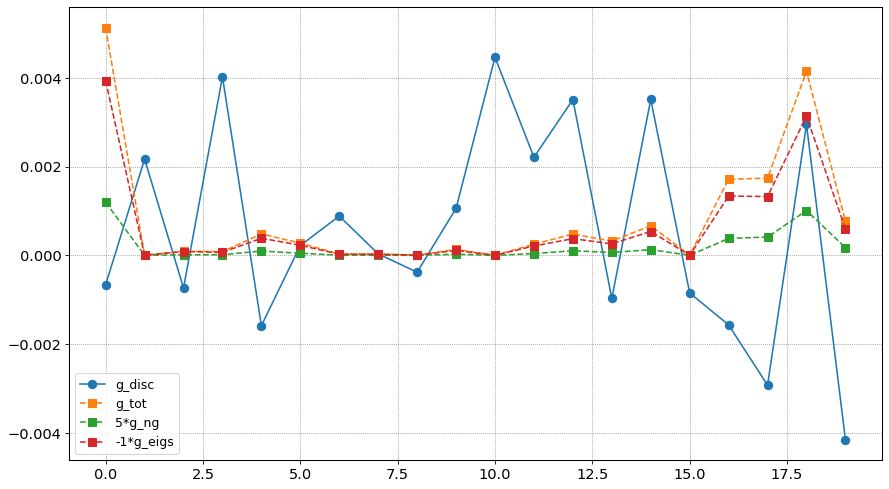

In [80]:
fig,ax = plt.subplots(1,1,figsize=(14,8))
ax.plot(g_disc_ng_0,'o-',color='C0',label='g_disc')
# ax.plot(-g_disc_ng_1,'o-',color='C1')
# ax.plot(-g_disc_ng_2,'o-',color='C2')

# factor = 1./60 # @ res = 32, 240 @ res = 64
# ax.plot(grad0[idx]*factor,'s--',color='C0')
# ax.plot(grad1[idx]*factor,'s--',color='C1')
# ax.plot(grad2[idx]*factor,'s--',color='C2')
# factor = -4


f0 = 5
f1 = -1

grad_eps_dr0 = self.gradient[1][:,0] 
grad_eps_dr1 = opt.gradient[2].sum(axis=1)
grad_eps_dr = f0*self.gradient[1][:,0] + f1*opt.gradient[2].sum(axis=1)

ax.plot(grad_eps_dr[idx],'s--',color='C1',label='g_tot')
ax.plot(f0*grad_eps_dr0[idx],'s--',color='C2',label=f'{f0}*g_ng')
ax.plot(f1*grad_eps_dr1[idx],'s--',color='C3',label=f'{f1}*g_eigs')

ax.legend()
# ax.plot(factor/grad_ng[idx],'s--',color='C0')

# ax.plot(grad0,'s--',color='C0')
# ax.plot(grad1,'s--',color='C1')
# ax.plot(grad2,'s--',color='C2')
# g_discrete
# ax.set_ylim([-0.05,1.6])

# ax.set_ylim([-0.015,0.015])
# ax.set_ylim([-0.007,0.007])

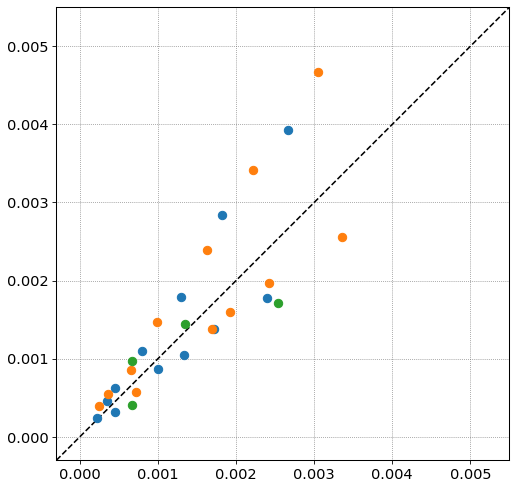

In [17]:
fig,ax = plt.subplots(1,1,figsize=(14,8))
glim = -0.0003,0.0055
factor = 1./60 # @ res = 32, 240 @ res = 64
#TM_factor = 4.5
ax.plot([glim[0],glim[1]],[glim[0],glim[1]],'--',color='k')

ax.plot(-g_disc0,grad0[idx]*factor,'o',color='C0')
ax.plot(-g_disc1,grad1[idx]*factor,'o',color='C1')
ax.plot(-g_disc2,grad2[idx]*factor,'o',color='C2')

# ax.plot(grad0,'s--',color='C0')
# ax.plot(grad1,'s--',color='C1')
# ax.plot(grad2,'s--',color='C2')
# g_discrete
# ax.set_ylim([-0.05,1.6])

ax.set_xlim(glim)
ax.set_ylim(glim)
ax.set_aspect('equal')

In [60]:
E = opt.E
H = opt.H
D = opt.D
eps = opt.epsilon
S = np.stack([np.array(opt.ms.get_poynting(mind+1)) for mind in range(opt.n_modes)],axis=-1)
# S = opt.S
U = np.stack([np.array(opt.ms.get_tot_pwr(mind+1)) for mind in range(opt.n_modes)],axis=-1)

ng = np.array([1 / ms.compute_one_group_velocity_component(mp.Vector3(0, 0, 1), band_ind+1) for band_ind in range(n_modes)])

D-energy-components:, 1, 1, 0.981138, 0.000682191, 0.0181796
B-energy-components:, 1, 1, 0.000728189, 0.967088, 0.0321834
D-energy-components:, 1, 2, 0.000898102, 0.962474, 0.0366282
B-energy-components:, 1, 2, 0.982717, 0.000578907, 0.0167038
D-energy-components:, 1, 3, 0.948679, 0.00881529, 0.0425055
B-energy-components:, 1, 3, 0.0099114, 0.961308, 0.0287808
D-energy-components:, 1, 4, 0.00986728, 0.958309, 0.0318237
B-energy-components:, 1, 4, 0.947822, 0.00825067, 0.0439274
D-energy-components:, 1, 5, 0.954688, 0.00397897, 0.0413327
B-energy-components:, 1, 5, 0.00495219, 0.968393, 0.0266552
D-energy-components:, 1, 6, 0.00447998, 0.966993, 0.0285272
B-energy-components:, 1, 6, 0.959648, 0.00316018, 0.0371917
D-energy-components:, 1, 7, 0.983792, 0.00179993, 0.0144082
B-energy-components:, 1, 7, 0.00270641, 0.930067, 0.0672262
D-energy-components:, 1, 8, 0.00823742, 0.933321, 0.0584419
B-energy-components:, 1, 8, 0.980161, 0.00687241, 0.0129668


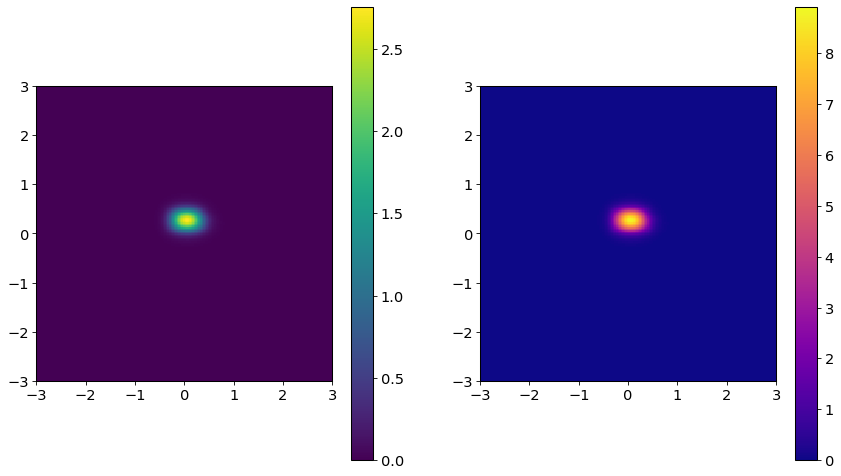

In [23]:
ax_ind = 2
mind = 0
zind = 0

# S.shape # (128, 128, 1, 3, 3)
# U.shape # (128, 128, 3)
fig,ax = plt.subplots(1,2,figsize=(14,8))
p0 = ax[0].pcolormesh(x,y,S[:,:,zind,ax_ind,mind].real.T,cmap=cm.viridis)
plt.colorbar(p0,ax=ax[0])

p1 = ax[1].pcolormesh(x,y,U[:,:,mind].real.T,cmap=cm.plasma)
plt.colorbar(p1,ax=ax[1])

for a in ax.flatten():
    a.set_aspect('equal')

In [143]:
1 / ( S[:,:,:,2,:].sum(axis=(0,1,2)).real / U.sum(axis = (0,1)) ) / 2.

array([1.64086459, 1.64172531, 1.65406534])

In [144]:
mind = 0
myS = np.stack([np.cross(np.conjugate(E[...,mind]),H[...,mind]) for mind in range(3)],axis=-1)
myU = np.stack([np.sum(eps.reshape(eps.shape+(1,1,))*np.abs(E[...,mind])**2+np.abs(H[...,mind])**2,axis=(2,3)) for mind in range(3)],axis=-1)


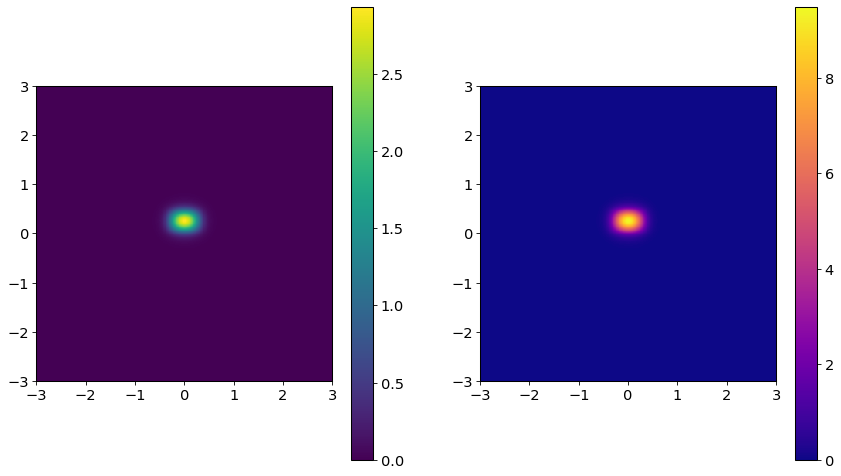

In [145]:
ax_ind = 2
mind = 0
zind = 0

# S.shape # (128, 128, 1, 3, 3)
# U.shape # (128, 128, 3)
fig,ax = plt.subplots(1,2,figsize=(14,8))
p0 = ax[0].pcolormesh(x,y,myS[:,:,zind,ax_ind,mind].real.T,cmap=cm.viridis)
plt.colorbar(p0,ax=ax[0])

p1 = ax[1].pcolormesh(x,y,myU[:,:,mind].real.T,cmap=cm.plasma)
plt.colorbar(p1,ax=ax[1])

for a in ax.flatten():
    a.set_aspect('equal')

In [146]:
1 / ( myS[:,:,:,2,:].sum(axis=(0,1,2)).real / myU.sum(axis = (0,1)) ) / 2.

array([1.64087465, 1.64182453, 1.654125  ])

In [68]:
# plot settings
E = opt.E
H = opt.H
D = opt.D
eps = opt.epsilon
S = np.stack([np.array(opt.ms.get_poynting(mind+1)) for mind in range(opt.n_modes)],axis=-1)
# S = opt.S
U = np.stack([np.array(opt.ms.get_tot_pwr(mind+1)) for mind in range(opt.n_modes)],axis=-1)
ng = np.array([1 / ms.compute_one_group_velocity_component(mp.Vector3(0, 0, 1), band_ind+1) for band_ind in range(n_modes)])


zind = 0
F = 'E'
xlim = -2,2
ylim = -0.5,1.5
figsize=(14,5 + 3*n_modes)

# opt.plot2D()

D-energy-components:, 1, 1, 0.981143, 0.00068341, 0.0181738
B-energy-components:, 1, 1, 0.000729213, 0.967087, 0.0321836
D-energy-components:, 1, 2, 0.000898533, 0.962468, 0.0366333
B-energy-components:, 1, 2, 0.982719, 0.000580177, 0.0167006
D-energy-components:, 1, 3, 0.94874, 0.00880457, 0.0424554
B-energy-components:, 1, 3, 0.00989977, 0.961312, 0.0287882
D-energy-components:, 1, 4, 0.00985763, 0.958318, 0.0318246
B-energy-components:, 1, 4, 0.947882, 0.00824058, 0.0438776
D-energy-components:, 1, 5, 0.954627, 0.00396507, 0.0414074
B-energy-components:, 1, 5, 0.00493885, 0.968387, 0.0266743
D-energy-components:, 1, 6, 0.00446736, 0.966982, 0.0285511
B-energy-components:, 1, 6, 0.959617, 0.00314715, 0.0372358
D-energy-components:, 1, 7, 0.983769, 0.00181846, 0.0144124
B-energy-components:, 1, 7, 0.00272712, 0.930064, 0.0672085
D-energy-components:, 1, 8, 0.0085777, 0.932888, 0.0585346
B-energy-components:, 1, 8, 0.979838, 0.00723018, 0.0129319


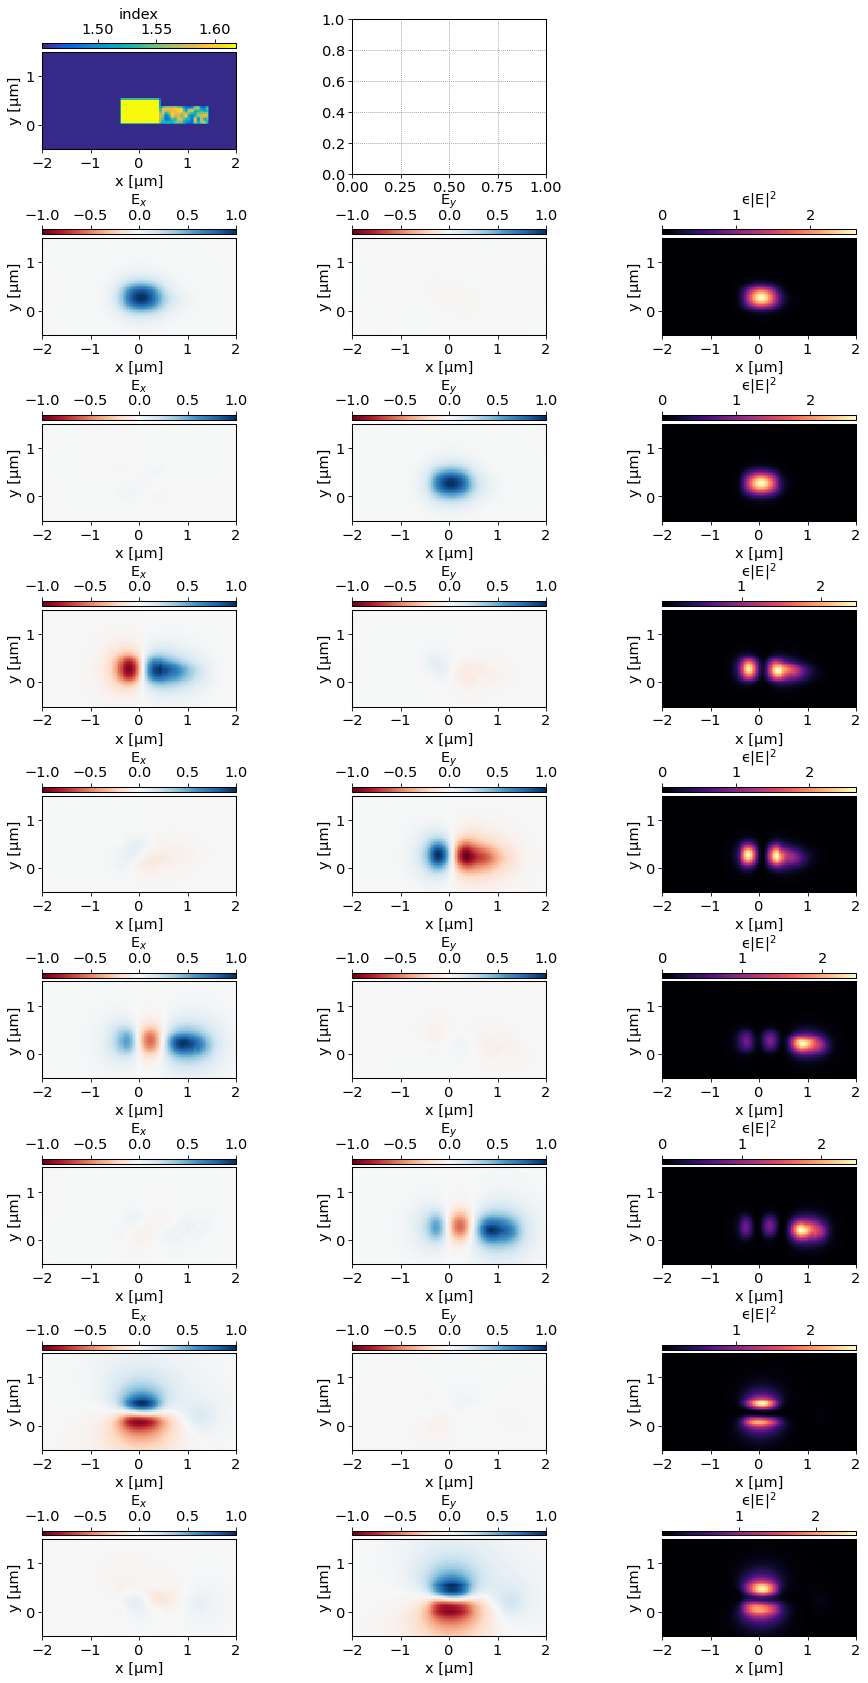

In [69]:
#### plot various computed fields for this instance ###
fig = plt.figure(figsize=figsize)
gs = GridSpec(n_modes+1,
              3,
              wspace=0.6,
              hspace=0.2,
             )

ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
#ax02 = fig.add_subplot(gs[0,2])



# # # prepare spatial coordinate vectors
# nx = eps.shape[0]
# ny = eps.shape[1]
# x = Xgrid * np.linspace(-1/2., 1/2., nx)
# y = Ygrid * np.linspace(-1/2., 1/2., ny)

# plot index as a function of space
p00 = ax00.pcolormesh(x,y,np.sqrt(eps.T),label='index')

# plot binary variable detecting core material
# p01 = ax01.pcolormesh(x,y,mat_core_mask.T,cmap=cm.Greys,label='core_mat')

# ax = [ax00,ax01,]
# p = [p00,p01,]
ax = [ax00,]
p = [p00,]

labels = ['index',
          'core_mat',
          'ϵ|E$_x$|$^2$',
          'E$_{x}$',
          'E$_{y}$',
          'E$_{z}$',
          'H$_{x}$',
          'H$_{y}$',
          'H$_{z}$',
         ]


for aind,a in enumerate(ax):
    if xlim:
        a.set_xlim(xlim)
    if ylim:
        a.set_ylim(ylim)
    a.set_aspect('equal')
    a.set_xlabel('x [μm]')
    a.set_ylabel('y [μm]')
    divider = make_axes_locatable(a)
    cax = divider.append_axes("top", size="5%", pad=0.05)
    cb = plt.colorbar(p[aind],
                 cax=cax,
                 orientation="horizontal",
                )
    cb.set_label(labels[aind])#,labelpad=-1)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')

####################################################################


for mind in range(n_modes):
    ax =  [fig.add_subplot(gs[1+mind,0]),
            fig.add_subplot(gs[1+mind,1]),
            fig.add_subplot(gs[1+mind,2]),
          ]
    
    
#     F_norm = E[...,zind,:,mind] / E[...,zind,:,mind].flatten()[np.argmax(np.abs(E[...,zind,:,mind]))]
    F_norm = E[...,zind,:,mind] / E[...,zind,:,mind].flatten()[np.argmax(np.abs(E[...,zind,:,mind]))]
    eps_ei2 = eps * ( np.abs(F_norm[:,:,0])**2 + np.abs(F_norm[:,:,1])**2 + np.abs(F_norm[:,:,2])**2 )
    labels = [
              'E$_{x}$',
              'E$_{y}$',
#               'E$_{z}$',
              'ϵ|E|$^2$',
    ]

    if F == "H":
        F_norm = H[...,zind,:,mind] / H[...,zind,:,mind].flatten()[np.argmax(np.abs(H[...,zind,:,mind]))]
        labels = [
                  'H$_{x}$',
                  'H$_{y}$',
    #               'H$_{z}$',
                   'ϵ|E|$^2$',
                 ]
    
    # plot Fx, Fy, Fz and ϵ|E|^2 
    vmax = np.abs(F_norm.real).max()
    vmin = -1 * np.abs(F_norm.real).max() #E_norm.real.min()

    


    axind = 0 
    p10 = ax[axind].pcolormesh(x,
                          y,
                          F_norm[:,:,axind].T.real,
                          cmap=cm.RdBu,
                          vmin=vmin,
                          vmax=vmax,
                         )

    axind = 1 
    p11 = ax[axind].pcolormesh(x,
                          y,
                          F_norm[:,:,axind].T.real,
                          cmap=cm.RdBu,
                          vmin=vmin,
                          vmax=vmax,
                         )

#     axind = 2
#     p12 = ax[axind].pcolormesh(x,
#                           y,
#                           F_norm[:,:,axind].T.real,
#                           cmap=cm.RdBu,
#                           vmin=vmin,
#                           vmax=vmax,
#                          )
    
    axind = 2
    p12 = ax[axind].pcolormesh(x,y,eps_ei2.T,cmap=cm.magma)







    ## format and label plots

#     ax = [ax10,ax11,ax12,ax13,ax20,ax21,ax22]
    p = [p10,p11,p12]
    




    for aind,a in enumerate(ax):
        if xlim:
            a.set_xlim(xlim)
        if ylim:
            a.set_ylim(ylim)
        a.set_aspect('equal')
        a.set_xlabel('x [μm]')
        a.set_ylabel('y [μm]')
        divider = make_axes_locatable(a)
        cax = divider.append_axes("top", size="5%", pad=0.05)
        cb = plt.colorbar(p[aind],
                     cax=cax,
                     orientation="horizontal",
                    )
        cb.set_label(labels[aind])#,labelpad=-1)
        cb.ax.xaxis.set_ticks_position('top')
        cb.ax.xaxis.set_label_position('top')

# print field energy integrals
res = ms.compute_field_energy()

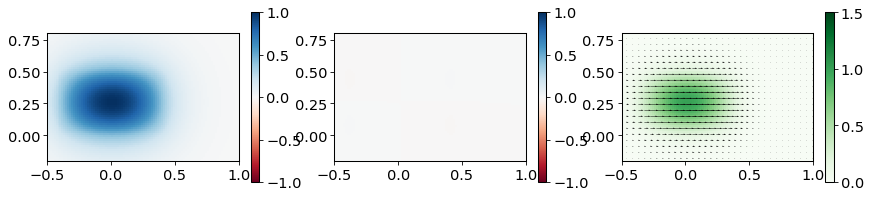

In [149]:
# Plot H field x-y components
res = 32
cmap = cm.Greens
zind = 0
ω_sq = ω**2
vmax = None
mind = 1
xlim = -0.5,1.0 #x.min(),x.max()
ylim = -0.2,0.8 #y.min(),y.max()
n_skip = 3
# xlim = 10,33 #x.min(),x.max()
# ylim = 10,33 #y.min(),y.max()

# axind = 1
# n_adj = np.abs(E[...,mind])**2

H_norm = H[...,zind,:,mind] / H[...,zind,:,mind].flatten()[np.argmax(np.abs(H[...,zind,:,mind]))]
fig,ax = plt.subplots(1,3,figsize=(14,3))


vmax =  1.5

px = ax[0].pcolormesh(x,
                 y,
                 H_norm[:,:,0].real.T,
                 vmin=-1,
                 vmax=1,
                 cmap=cm.RdBu,
                )
plt.colorbar(px,ax=ax[0])
py = ax[1].pcolormesh(x,
                 y,
                 H_norm[:,:,1].real.T,
                 vmin=-1,
                 vmax=1,
                 cmap=cm.RdBu,
                )
plt.colorbar(py,ax=ax[1])
p = ax[2].pcolormesh(x,
                 y,
                 np.sum(np.abs(H_norm)**2,axis=-1).T,
                 vmin=0,
                 vmax=vmax,
                 cmap=cmap,
                )
plt.colorbar(p)
Q = ax[2].quiver(x[::n_skip],
              y[::n_skip],
              H_norm[::n_skip,::n_skip,0].real.T,
              H_norm[::n_skip,::n_skip,1].real.T,
              scale=16, #0.25/(x[1]-x[0]),
#               units='xy',
             )



# p = plt.pcolormesh(x,y,n_adj[...,zind,axind].T,vmax=vmax)

for a in ax:
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_aspect('equal')

## H field FFT

In [195]:
np.fft.fft2(H_norm[:,:,1]).shape

(128, 128)

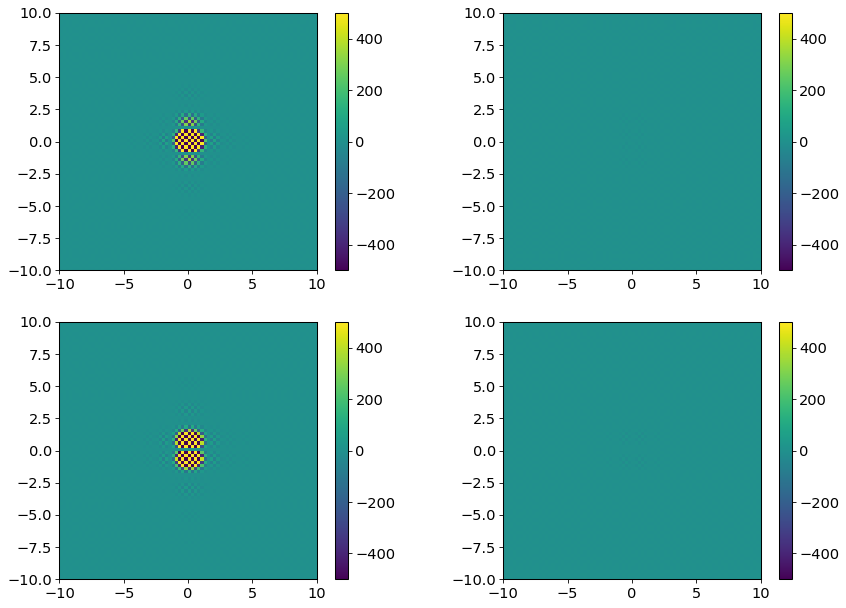

In [256]:
k = opt.k_points[0]
mind = 1
fig,ax = plt.subplots(2,2,figsize=(14,10))
H_norm = H[...,zind,:,mind] #/ H[...,zind,:,mind].flatten()[np.argmax(np.abs(H[...,zind,:,mind]))]
# H_norm = E[...,zind,:,mind]
xlim = -10,10
ylim = -10,10
fft_axes = 1,0
vmax =   500
vmin = -vmax
cmap = cm.viridis
vmax_mag = 300

kx = np.fft.fftshift(np.fft.fftfreq(opt.Nx,d=opt.x[1]-opt.x[0]))
ky = np.fft.fftshift(np.fft.fftfreq(opt.Ny,d=opt.y[1]-opt.y[0]))
Zx = np.fft.fftshift(np.fft.fft2(H_norm[:,:,0],axes=fft_axes)).T
Zy = np.fft.fftshift(np.fft.fft2(H_norm[:,:,1],axes=fft_axes)).T


# kx = np.fft.fftfreq(opt.Nx,d=opt.x[1]-opt.x[0])
# ky = np.fft.fftfreq(opt.Ny,d=opt.y[1]-opt.y[0])
# Zx = np.fft.fft2(H_norm[:,:,0])
# Zy = np.fft.fft2(H_norm[:,:,1])



# Zx = sp.fft.fftshift(sp.fft.fftn(H_norm[:,:,0],axes=fft_axes),axes=fft_axes).T
# Zy = sp.fft.fftshift(sp.fft.fftn(H_norm[:,:,1],axes=fft_axes),axes=fft_axes).T

# Zx = sp.fft.ifftn(sp.fft.ifftshift(H_norm[:,:,0],axes=fft_axes),axes=fft_axes).T
# Zy = sp.fft.ifftn(sp.fft.ifftshift(H_norm[:,:,1],axes=fft_axes),axes=fft_axes).T


prx = ax[0,0].pcolormesh(kx,ky,
                 Zx.real,
                 vmin=vmin,
                 vmax=vmax,
                 cmap=cmap,
                )
plt.colorbar(prx,ax=ax[0,0])

pix = ax[1,0].pcolormesh(kx,ky,
                 Zx.imag,
                 vmin=vmin,
                 vmax=vmax,
                 cmap=cmap,
                )
plt.colorbar(pix,ax=ax[1,0])



pry = ax[0,1].pcolormesh(kx,ky,
                 Zy.real,
                 vmin=vmin,
                 vmax=vmax,
                 cmap=cmap,
                )
plt.colorbar(pry,ax=ax[0,1])

piy = ax[1,1].pcolormesh(kx,ky,
                 Zy.imag,
                 vmin=vmin,
                 vmax=vmax,
                 cmap=cmap,
                )
plt.colorbar(piy,ax=ax[1,1])

# p = ax[0,2].pcolormesh(
#                  np.fft.fft2(np.sum(np.abs(H_norm)**2,axis=-1)).real.T,
#                  vmin=0,
#                  vmax=vmax_mag,
#                  cmap=cmap,
#                 )

# p = ax[1,2].pcolormesh(
#                  np.fft.fft2(np.sum(np.abs(H_norm)**2,axis=-1)).imag.T,
#                  vmin=0,
#                  vmax=vmax_mag,
#                  cmap=cmap,
#                 )


# plt.colorbar(p)
# Q = ax[2].quiver(x[::n_skip],
#               y[::n_skip],
#               H_norm[::n_skip,::n_skip,0].real.T,
#               H_norm[::n_skip,::n_skip,1].real.T,
#               scale=16, #0.25/(x[1]-x[0]),
# #               units='xy',
#              )



# p = plt.pcolormesh(x,y,n_adj[...,zind,axind].T,vmax=vmax)

for a in ax.flatten():
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_aspect('equal')


## ε$^{-1}$ tensor field

In [150]:
# xind = 100
# yind = 100


ε_inv = np.stack([np.stack([ np.array(opt.ms.get_epsilon_inverse_tensor_point(mp.Vector3(x[xind],y[yind]))) for yind in range(opt.Ny)],axis=0) for xind in range(opt.Nx)],axis=0)


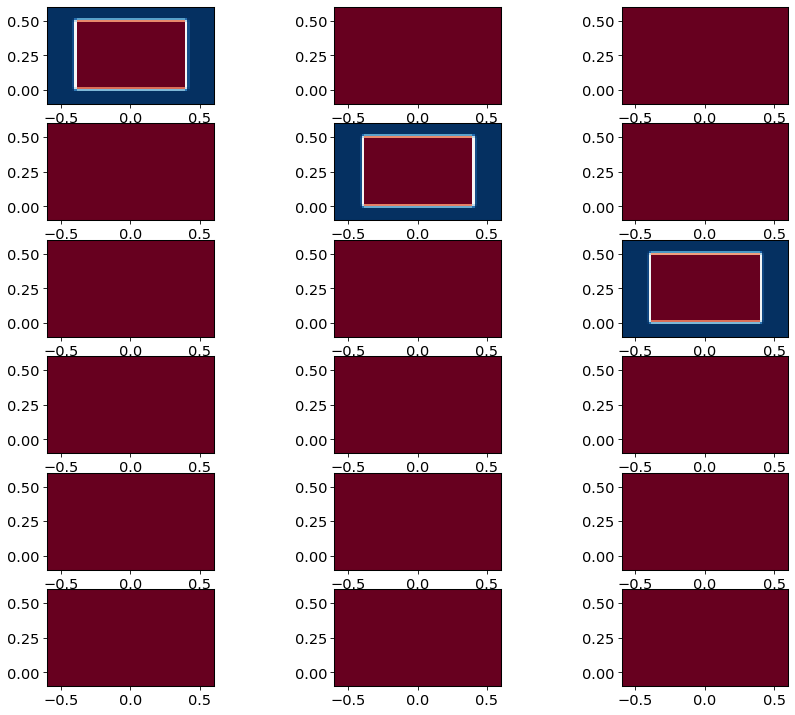

In [151]:
# plot ε_inv
xlim = -0.6, 0.6
ylim = -0.1,0.6
fig,ax = plt.subplots(6,3,figsize=(14,12))

######### original  #########



for xind in range(3):
    for yind in range(3):
        ax[yind,xind].pcolormesh(x,
                                   y,
                                   ε_inv[:,:,xind,yind].real.T,
#                                    vmin=vmin,
#                                    vmax=vmax,
                                   cmap=cm.RdBu,
                                  )
        
        ax[yind+3,xind].pcolormesh(x,
                           y,
                           ε_inv[:,:,xind,yind].imag.T,
#                            vmin=vmin,
#                            vmax=vmax,
                           cmap=cm.RdBu,
                          )

for a in ax.flatten():
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_aspect('equal')


In [21]:
ε_inv.shape

(256, 256, 3, 3)

## E from H

In [445]:
# plot settings and field calcs, full
mind = 1
figsize= (14,15)
xlim = -0.8, 0.8
ylim = -0.4,0.8

F = E
kz = 2.8
a = 1. / kz / 2.

# calc curl_H
# dHx_dx, dHx_dy = np.gradient(H[:,:,0,0,mind],x/a,y/a)
# dHy_dx, dHy_dy = np.gradient(H[:,:,0,1,mind],x/a,y/a)
# dHz_dx, dHz_dy = np.gradient(H[:,:,0,2,mind],x/a,y/a)

dx = x[1] - x[0]
dy = y[1] - y[0]
dHx_dx = np.gradient(H[:,:,0,0,mind],axis=0) / ( dx / a )
dHy_dx = np.gradient(H[:,:,0,1,mind],axis=0) / ( dx / a )
dHz_dx = np.gradient(H[:,:,0,2,mind],axis=0) / ( dx / a )
dHx_dy = np.gradient(H[:,:,0,0,mind],axis=1) / ( dy / a )
dHy_dy = np.gradient(H[:,:,0,1,mind],axis=1) / ( dy / a )
dHz_dy = np.gradient(H[:,:,0,2,mind],axis=1) / ( dy / a )



curl_H = np.stack([dHz_dy - 1j * kz * H[:,:,0,1,mind],
                   1j * kz * H[:,:,0,0,mind] - dHz_dx,
                   dHy_dx - dHx_dy,
                  ],axis=-1)

# xind = 100
# yind = 100
# ε_inv = opt.ms.get_epsilon_inverse_tensor_point(mp.Vector3(x[xind],y[yind]))

# np.array(ε_inv)

ω = np.array(opt.ms.freqs)


# calculate F (E or D) from H and compare with MPB-returned version

# method one: divide by diagonal (dumb way)
myF0 = (1j / ω[mind]) * curl_H  / opt.epsilon[:,:,np.newaxis]


# method two: non-vectorized ε_inv tensor field operating at each position
myF1 = np.zeros_like(curl_H)
for xind in range(curl_H.shape[0]):
    for yind in range(curl_H.shape[1]):
#         myF1[xind,yind,:] = (1j / ω[mind]) * curl_H[xind,yind,:]
        myF1[xind,yind,:] = (1j / ω[mind]) * np.dot(ε_inv[xind,yind,:,:],curl_H[xind,yind,:])

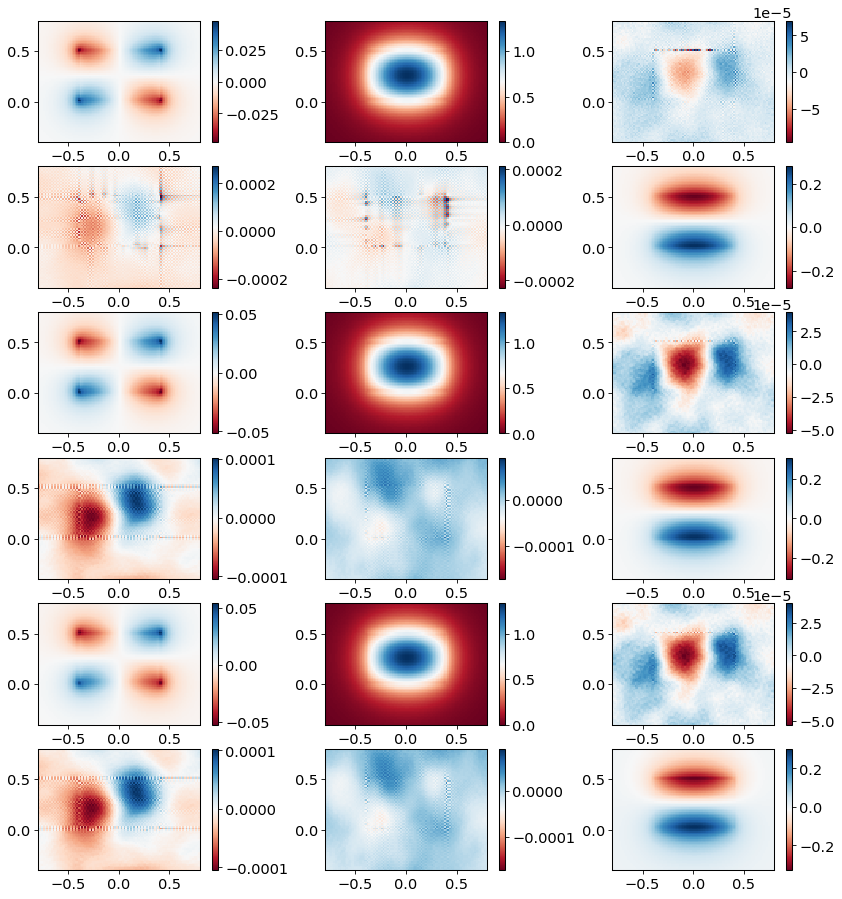

In [446]:
# plot MPB-calculated field against my version for comparision
        
fig,ax = plt.subplots(6,3,figsize=figsize)

######### original  #########

p00 = ax[0,0].pcolormesh(x,
                   y,
                   F[:,:,0,0,mind].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p00,ax=ax[0,0])
p01 = ax[0,1].pcolormesh(x,
                   y,
                   F[:,:,0,1,mind].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p01,ax=ax[0,1])
p02 = ax[0,2].pcolormesh(x,
                   y,
                   F[:,:,0,2,mind].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p02,ax=ax[0,2])
p10 = ax[1,0].pcolormesh(x,
                   y,
                   F[:,:,0,0,mind].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p10,ax=ax[1,0])
p11 = ax[1,1].pcolormesh(x,
                   y,
                   F[:,:,0,1,mind].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p11,ax=ax[1,1])
p12 = ax[1,2].pcolormesh(x,
                   y,
                   F[:,:,0,2,mind].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p12,ax=ax[1,2])
######### method 1  #########

p20 = ax[2,0].pcolormesh(x,
                   y,
                   myF0[:,:,0].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p20,ax=ax[2,0])
p21 = ax[2,1].pcolormesh(x,
                   y,
                   myF0[:,:,1].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p21,ax=ax[2,1])
p22 = ax[2,2].pcolormesh(x,
                   y,
                   myF0[:,:,2].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p22,ax=ax[2,2])

p30 = ax[3,0].pcolormesh(x,
                   y,
                   myF0[:,:,0].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p30,ax=ax[3,0])
p31 = ax[3,1].pcolormesh(x,
                   y,
                   myF0[:,:,1].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p31,ax=ax[3,1])
p32 = ax[3,2].pcolormesh(x,
                   y,
                   myF0[:,:,2].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p32,ax=ax[3,2])


# ######### method 2  #########

p40 = ax[4,0].pcolormesh(x,
                   y,
                   myF1[:,:,0].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p40,ax=ax[4,0])
p41 = ax[4,1].pcolormesh(x,
                   y,
                   myF1[:,:,1].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p41,ax=ax[4,1])
p42 = ax[4,2].pcolormesh(x,
                   y,
                   myF1[:,:,2].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p42,ax=ax[4,2])

p50 = ax[5,0].pcolormesh(x,
                   y,
                   myF1[:,:,0].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p50,ax=ax[5,0])
p51 = ax[5,1].pcolormesh(x,
                   y,
                   myF1[:,:,1].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p51,ax=ax[5,1])
p52 = ax[5,2].pcolormesh(x,
                   y,
                   myF1[:,:,2].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p52,ax=ax[5,2])

for a in ax.flatten():
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_aspect('equal')

### First term of curl components

In [129]:
# plot settings and field calcs, first curl term only 
figsize= 14,5

curl_H = np.stack([dHz_dy ,
                   1j * kz * H[:,:,0,0,mind] ,
                   dHy_dx ,
                  ],axis=-1)

# xind = 100
# yind = 100
# ε_inv = opt.ms.get_epsilon_inverse_tensor_point(mp.Vector3(x[xind],y[yind]))

# np.array(ε_inv)

ω = np.array(opt.ms.freqs)


# calculate F (E or D) from H and compare with MPB-returned version

# method one: divide by diagonal (dumb way)
myF0 = (1j / ω[mind]) * curl_H # / opt.epsilon[:,:,np.newaxis] /  ω[np.newaxis,np.newaxis,:]


# method two: non-vectorized ε_inv tensor field operating at each position
myF1 = np.zeros_like(curl_H)
for xind in range(curl_H.shape[0]):
    for yind in range(curl_H.shape[1]):
        myF1[xind,yind,:] = (1j / ω[mind]) * curl_H[xind,yind,:]
#         myF1[xind,yind,:] = -np.dot(ε_inv[xind,yind,:,:],curl_H[xind,yind,:]) /  ω[mind]

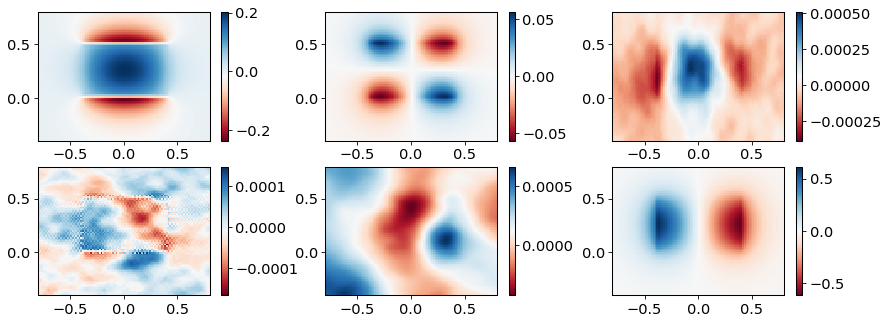

In [130]:
# plot MPB-calculated field against my version for comparision
        
fig,ax = plt.subplots(2,3,figsize=figsize)


######### method 1  #########

p00 = ax[0,0].pcolormesh(x,
                   y,
                   myF0[:,:,0].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p00,ax=ax[0,0])
p01 = ax[0,1].pcolormesh(x,
                   y,
                   myF0[:,:,1].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p01,ax=ax[0,1])
p02 = ax[0,2].pcolormesh(x,
                   y,
                   myF0[:,:,2].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p02,ax=ax[0,2])

p10 = ax[1,0].pcolormesh(x,
                   y,
                   myF0[:,:,0].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p10,ax=ax[1,0])
p11 = ax[1,1].pcolormesh(x,
                   y,
                   myF0[:,:,1].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p11,ax=ax[1,1])
p12 = ax[1,2].pcolormesh(x,
                   y,
                   myF0[:,:,2].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p12,ax=ax[1,2])


for a in ax.flatten():
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_aspect('equal')

### Second term of curl components

In [131]:
# plot settings and field calcs, 2nd curl term only
figsize= 14,5

curl_H = np.stack([-1j * kz * H[:,:,0,1,mind],
                   -dHz_dx,
                   -dHx_dy,
                  ],axis=-1)

# xind = 100
# yind = 100
# ε_inv = opt.ms.get_epsilon_inverse_tensor_point(mp.Vector3(x[xind],y[yind]))

# np.array(ε_inv)

ω = np.array(opt.ms.freqs)


# calculate F (E or D) from H and compare with MPB-returned version

# method one: divide by diagonal (dumb way)
myF0 = (1j / ω[mind]) * curl_H # / opt.epsilon[:,:,np.newaxis] /  ω[np.newaxis,np.newaxis,:]


# method two: non-vectorized ε_inv tensor field operating at each position
myF1 = np.zeros_like(curl_H)
for xind in range(curl_H.shape[0]):
    for yind in range(curl_H.shape[1]):
        myF1[xind,yind,:] = (1j / ω[mind]) * curl_H[xind,yind,:]
#         myF1[xind,yind,:] = -np.dot(ε_inv[xind,yind,:,:],curl_H[xind,yind,:]) /  ω[mind]

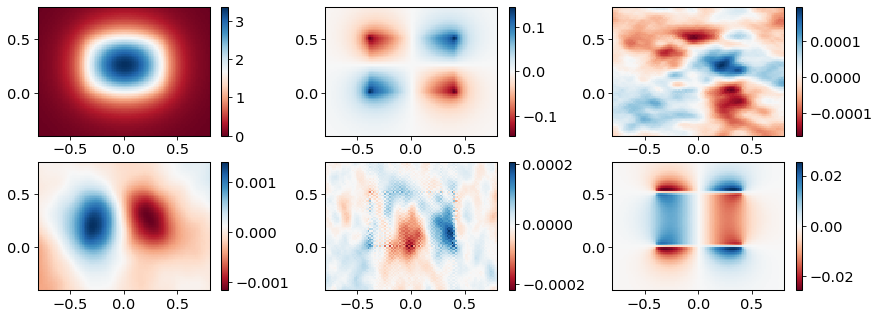

In [132]:
# plot MPB-calculated field against my version for comparision
        
fig,ax = plt.subplots(2,3,figsize=figsize)


######### method 1  #########

p00 = ax[0,0].pcolormesh(x,
                   y,
                   myF0[:,:,0].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p00,ax=ax[0,0])
p01 = ax[0,1].pcolormesh(x,
                   y,
                   myF0[:,:,1].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p01,ax=ax[0,1])
p02 = ax[0,2].pcolormesh(x,
                   y,
                   myF0[:,:,2].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p02,ax=ax[0,2])

p10 = ax[1,0].pcolormesh(x,
                   y,
                   myF0[:,:,0].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p10,ax=ax[1,0])
p11 = ax[1,1].pcolormesh(x,
                   y,
                   myF0[:,:,1].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p11,ax=ax[1,1])
p12 = ax[1,2].pcolormesh(x,
                   y,
                   myF0[:,:,2].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p12,ax=ax[1,2])


for a in ax.flatten():
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_aspect('equal')

## H from E

In [158]:
# plot settings and field calcs, full
mind = 0
figsize= (14,12)
xlim = -0.8, 0.8
ylim = -0.4,0.8

F = H
kz = 2.8
a = 1. / kz / 2.

# calc curl_H
dEx_dx, dEx_dy = np.gradient(E[:,:,0,0,mind],x/a,y/a)
dEy_dx, dEy_dy = np.gradient(E[:,:,0,1,mind],x/a,y/a)
dEz_dx, dEz_dy = np.gradient(E[:,:,0,2,mind],x/a,y/a)


curl_E = np.stack([dEz_dy - 1j * kz * E[:,:,0,1,mind],
                   1j * kz * E[:,:,0,0,mind] - dEz_dx,
                   dEy_dx - dEx_dy,
                  ],
                  axis=-1,
                 )

# xind = 100
# yind = 100
# ε_inv = opt.ms.get_epsilon_inverse_tensor_point(mp.Vector3(x[xind],y[yind]))

# np.array(ε_inv)

ω = np.array(opt.ms.freqs)


# calculate F (E or D) from H and compare with MPB-returned version

# method one: divide by diagonal (dumb way)
myH = (-1j / ω[mind]) * curl_E 


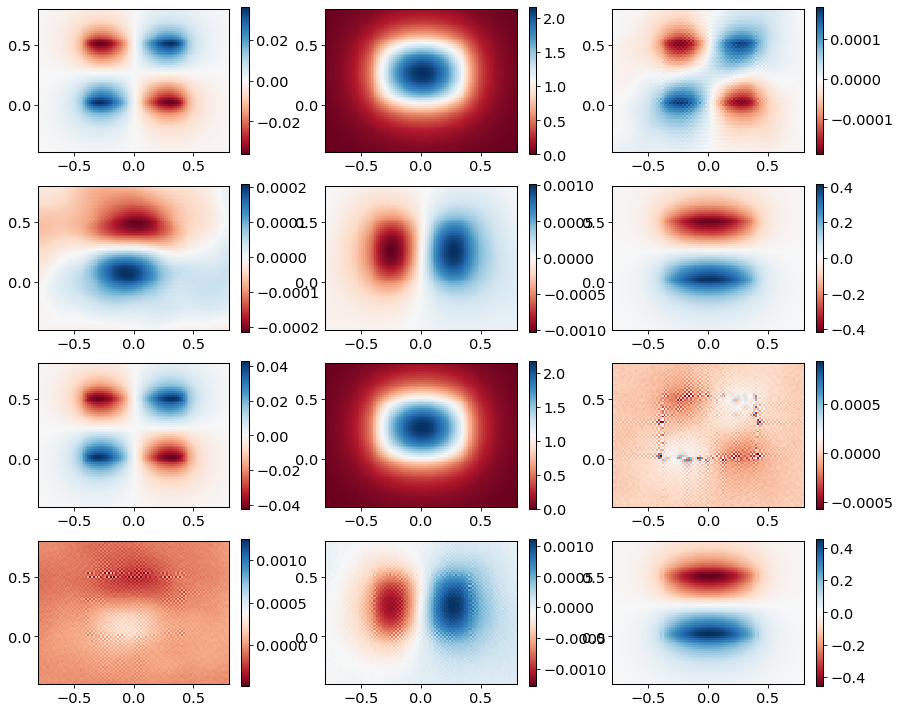

In [159]:
# plot MPB-calculated field against my version for comparision
        
fig,ax = plt.subplots(4,3,figsize=figsize)

######### original  #########

p00 = ax[0,0].pcolormesh(x,
                   y,
                   F[:,:,0,0,mind].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p00,ax=ax[0,0])
p01 = ax[0,1].pcolormesh(x,
                   y,
                   F[:,:,0,1,mind].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p01,ax=ax[0,1])
p02 = ax[0,2].pcolormesh(x,
                   y,
                   F[:,:,0,2,mind].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p02,ax=ax[0,2])
p10 = ax[1,0].pcolormesh(x,
                   y,
                   F[:,:,0,0,mind].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p10,ax=ax[1,0])
p11 = ax[1,1].pcolormesh(x,
                   y,
                   F[:,:,0,1,mind].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p11,ax=ax[1,1])
p12 = ax[1,2].pcolormesh(x,
                   y,
                   F[:,:,0,2,mind].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p12,ax=ax[1,2])
######### method 1  #########

p20 = ax[2,0].pcolormesh(x,
                   y,
                   myH[:,:,0].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p20,ax=ax[2,0])
p21 = ax[2,1].pcolormesh(x,
                   y,
                   myH[:,:,1].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p21,ax=ax[2,1])
p22 = ax[2,2].pcolormesh(x,
                   y,
                   myH[:,:,2].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p22,ax=ax[2,2])

p30 = ax[3,0].pcolormesh(x,
                   y,
                   myH[:,:,0].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p30,ax=ax[3,0])
p31 = ax[3,1].pcolormesh(x,
                   y,
                   myH[:,:,1].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p31,ax=ax[3,1])
p32 = ax[3,2].pcolormesh(x,
                   y,
                   myH[:,:,2].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p32,ax=ax[3,2])




for a in ax.flatten():
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_aspect('equal')

## S from H

In [370]:
import scipy.integrate as integrate

In [385]:
# plot settings and field calcs, full
mind = 1
figsize= (14,15)
xlim = -0.8, 0.8
ylim = -0.4,0.8

kz = 2.8
a = 1. / kz / 2.

# calc curl_H

def curl2D(V,x,y,kz,a=1):
    # calculate and return the curl of the 2D 3-vector field V(x,y) = [Vx(x,y),Vy(x,y),Vz(x,y)]
    # for MPB scaled spatial coordiantes x and y with scaling factor a (= 1/(2*kz) ?)
    # and an assumed spatial period along z of kz
    dVx_dx, dVx_dy = np.gradient(V[:,:,0],x/a,y/a)
    dVy_dx, dVy_dy = np.gradient(V[:,:,1],x/a,y/a)
    dVz_dx, dVz_dy = np.gradient(V[:,:,2],x/a,y/a)
    curl_V = np.stack([dVz_dy - 1j * kz * V[:,:,1],
                       1j * kz * V[:,:,0] - dVz_dx,
                       dVy_dx - dVx_dy,
                      ],
                      axis=-1)
    return curl_V

######## calculate E from H ########

# curl_H = np.stack([curl2D(H,x,y,kz,a=a) for mind in range(3)],axis=-1)
ω = np.array(opt.ms.freqs)

### method one: divide by diagonal (dumb way) ###
myE = (1j / ω[mind]) * np.stack([curl2D(np.squeeze(H[...,mind]),x,y,kz,a=a) for mind in range(3)],axis=-1)  / opt.epsilon[:,:,np.newaxis,np.newaxis]

### method two: non-vectorized ε_inv tensor field operating at each position ###
# myE = np.zeros_like(curl_H)
# for xind in range(curl_H.shape[0]):
#     for yind in range(curl_H.shape[1]):
#         myE[xind,yind,:] = (1j / ω[mind]) * np.dot(ε_inv[xind,yind,:,:],curl_H[xind,yind,:])


######## calculate S and U from E and H ########

myS = np.stack([np.cross(np.conjugate(myE[...,mind]),np.squeeze(H[...,mind])) for mind in range(3)],axis=-1)
myU = np.stack([np.sum(eps.reshape(eps.shape+(1,))*np.abs(myE[...,mind])**2+np.abs(np.squeeze(H[...,mind]))**2,axis=2) for mind in range(3)],axis=-1)

# reference ng calculated internally by MPB
ng = np.array([1 / opt.ms.compute_one_group_velocity_component(mp.Vector3(0, 0, 1), band_ind+1) for band_ind in range(n_modes)])
# reference ng calculated externally using fields from MPB
ng_int = 1 / ( S[:,:,:,2,:].sum(axis=(0,1,2)).real / U.sum(axis = (0,1)) ) / 2.

######## calculate ng (geometric portion only) from S and U ##########

my_ng = 1 / ( myS[:,:,2,:].sum(axis=(0,1)).real / myU.sum(axis = (0,1)) ) / 2.
# my_ng / ng: [1.00307513 1.00468996 1.00528764]

# my_ng = 1 / ( integrate.simps(integrate.simps(myS[:,:,2,:].real,x=y,axis=1),x=x,axis=0) / integrate.simps(integrate.simps(myU.real,x=y,axis=1),x=x,axis=0) ) / 2.
# my_ng / ng: [1.00307513 1.00468996 1.00528764]

######## calculate ng from H more directly ##########

def ng2D(H,eps_inv,x,y,ω):
    V = np.zeros_like(np.squeeze(H))
    V[:,:,0,:] = -1j* np.squeeze(H)[:,:,1,:]
    V[:,:,1,:] = 1j* np.squeeze(H)[:,:,0,:]
    X = np.stack([curl2D(V[...,mind]*eps_inv,x,y,kz,a=a) for mind in range(3)],axis=-1)
    Z = np.conjugate(np.squeeze(H))*X 
    print('Z.shape:')
    print(Z.shape)
#     dx = np.mean(np.diff(x))
#     dy = np.mean(np.diff(y))
#     Zint = np.sum(Z,axis=(0,1,2)).real * (dx * dy)
    Zint = integrate.simps(integrate.simps(np.sum(Z,axis=2).real,x=y,axis=1),x=x,axis=0)
    return ((1 / (Zint )) * ω)

my_ng_alt = ng2D(H,1/opt.epsilon[:,:,np.newaxis],x,y,ω)

print(f'ng: {ng}')
print(f'ng_int: {ng_int}')
print(f'my_ng: {my_ng}')
print(f'my_ng / ng: {my_ng/ng}')
print(f'my_ng_alt: {my_ng_alt}')
print(f'my_ng_alt / ng: {my_ng_alt/ng}')



Z.shape:
(384, 384, 3, 3)
ng: [1.64086459 1.64172531 1.65406534]
ng_int: [1.64086459 1.64172531 1.65406534]
my_ng: [1.64591046 1.64942493 1.66281144]
my_ng / ng: [1.00307513 1.00468996 1.00528764]
my_ng_alt: [1.62681447 1.62982735 1.63373461]
my_ng_alt / ng: [0.99143737 0.99275277 0.98770863]


In [375]:
V = np.zeros_like(np.squeeze(H))
V[:,:,0,:] = -1j* np.squeeze(H)[:,:,1,:]
V[:,:,1,:] = 1j* np.squeeze(H)[:,:,0,:]
X = np.stack([curl2D(V[...,mind]/ opt.epsilon[:,:,np.newaxis],x,y,kz,a=a) for mind in range(3)],axis=-1)
# Z = np.conjugate(np.squeeze(H))*X
# Zint = np.sum(Z,axis=(0,1,2)).real
Z = np.conjugate(np.squeeze(H))*X
dx = np.mean(np.diff(x))
dy = np.mean(np.diff(y))
Zint = np.sum(Z,axis=(0,1,2)).real

new_ng = 1/((Zint * (dx * dy)) * ω)# * ng
# new_ng = (Zint / ((opt.Nx-1)* (opt.Ny-1)) / ω / 2)
new_ng

array([0.50035993, 0.49952283, 0.46623862])

In [365]:
Z = np.conjugate(np.squeeze(H))*X
dx = np.mean(np.diff(x))
dy = np.mean(np.diff(y))
Zint = np.sum(Z,axis=(0,1,2)).real #/ opt.Nx / opt.Ny

In [366]:
# (1 / (Zint / opt.N)) / ng
(Zint / opt.N / ω / 2) # * ng

array([1.63066897, 1.62765453, 1.62376182])

In [368]:
ng / ((1 / (Zint * (dx * dy))) * ω)

array([1.00863659, 1.00730014, 1.01244433])

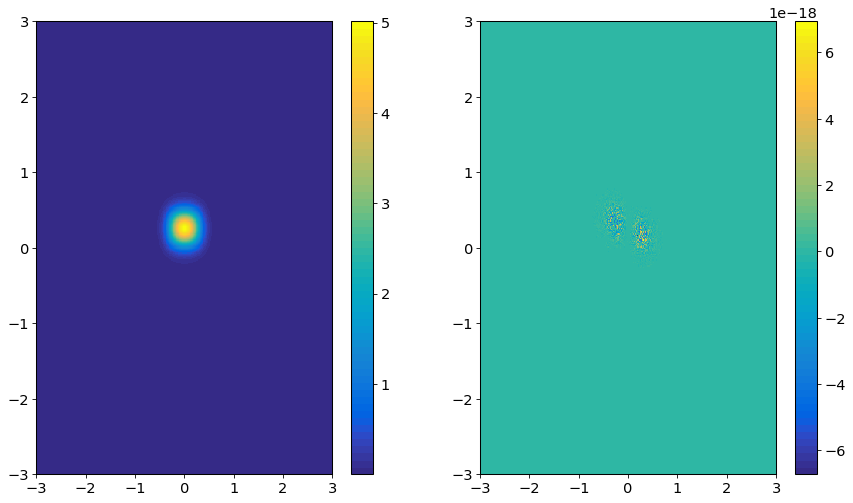

In [363]:
mind = 1
fig,ax = plt.subplots(1,2,figsize=(14,8))

p0 = ax[0].pcolormesh(x,y,np.sum(Z[:,:,mind],axis=2).real.T)
plt.colorbar(p0,ax=ax[0])
p1 = ax[1].pcolormesh(x,y,np.sum(Z[:,:,mind],axis=2).imag.T)
plt.colorbar(p1,ax=ax[1])

In [336]:
dx

0.015665796344647376

In [302]:

1 / Zint.real / kz / ω / 4 /ng

array([0.98527885, 0.98311478, 0.91076212])

In [268]:
#ω * 4
dx

0.015665796344647376

In [215]:
mind = 0

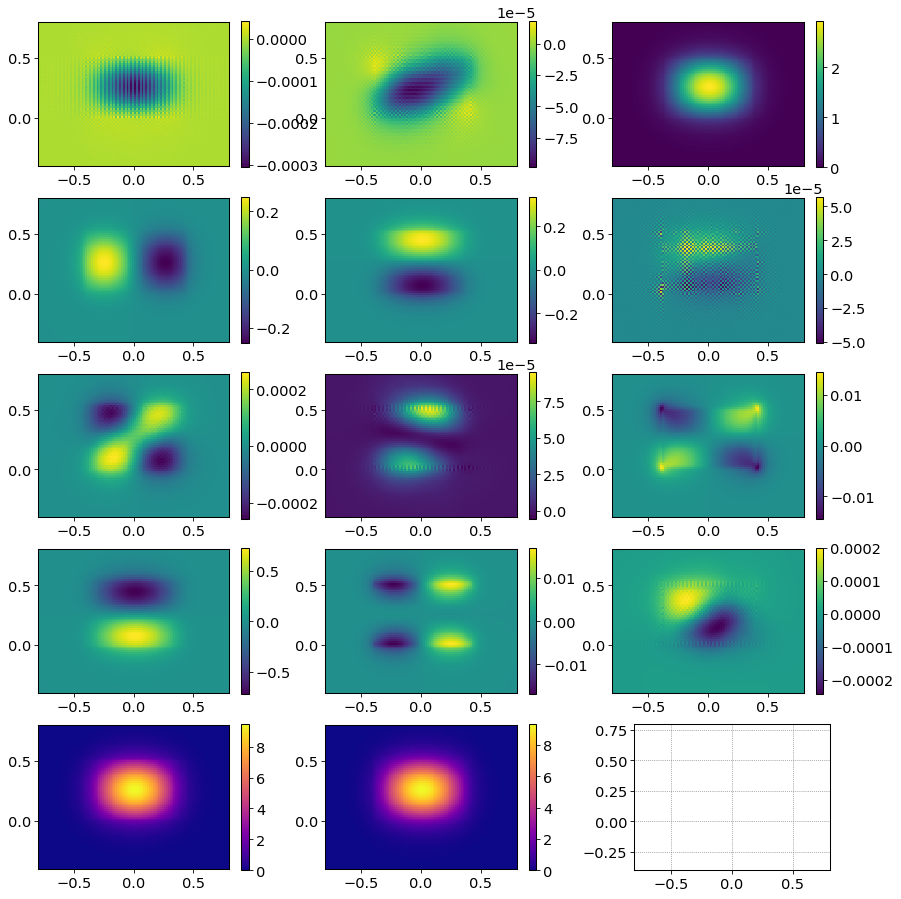

In [216]:
# plot MPB-calculated S and U fields against my versions for comparision
        
fig,ax = plt.subplots(5,3,figsize=figsize)

######### original S  #########

p00 = ax[0,0].pcolormesh(x,
                   y,
                   S[:,:,0,0,mind].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.viridis,
                  )
plt.colorbar(p00,ax=ax[0,0])
p01 = ax[0,1].pcolormesh(x,
                   y,
                   S[:,:,0,1,mind].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.viridis,
                  )
plt.colorbar(p01,ax=ax[0,1])
p02 = ax[0,2].pcolormesh(x,
                   y,
                   S[:,:,0,2,mind].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.viridis,
                  )
plt.colorbar(p02,ax=ax[0,2])
p10 = ax[1,0].pcolormesh(x,
                   y,
                   S[:,:,0,0,mind].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.viridis,
                  )
plt.colorbar(p10,ax=ax[1,0])
p11 = ax[1,1].pcolormesh(x,
                   y,
                   S[:,:,0,1,mind].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.viridis,
                  )
plt.colorbar(p11,ax=ax[1,1])
p12 = ax[1,2].pcolormesh(x,
                   y,
                   S[:,:,0,2,mind].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.viridis,
                  )
plt.colorbar(p12,ax=ax[1,2])

######### myS  #########

p20 = ax[2,0].pcolormesh(x,
                   y,
                   myS[:,:,0,mind].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.viridis,
                  )
plt.colorbar(p20,ax=ax[2,0])
p21 = ax[2,1].pcolormesh(x,
                   y,
                   myS[:,:,1,mind].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.viridis,
                  )
plt.colorbar(p21,ax=ax[2,1])
p22 = ax[2,2].pcolormesh(x,
                   y,
                   myS[:,:,2,mind].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.viridis,
                  )
plt.colorbar(p22,ax=ax[2,2])

p30 = ax[3,0].pcolormesh(x,
                   y,
                   myS[:,:,0,mind].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.viridis,
                  )
plt.colorbar(p30,ax=ax[3,0])
p31 = ax[3,1].pcolormesh(x,
                   y,
                   myS[:,:,1,mind].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.viridis,
                  )
plt.colorbar(p31,ax=ax[3,1])
p32 = ax[3,2].pcolormesh(x,
                   y,
                   myS[:,:,2,mind].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.viridis,
                  )
plt.colorbar(p32,ax=ax[3,2])


# ######### U and my U  #########

p40 = ax[4,0].pcolormesh(x,
                   y,
                   U[:,:,mind].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.plasma,
                  )
plt.colorbar(p40,ax=ax[4,0])
p41 = ax[4,1].pcolormesh(x,
                   y,
                   myU[:,:,mind].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.plasma,
                  )
plt.colorbar(p41,ax=ax[4,1])

# p42 = ax[4,2].pcolormesh(x,
#                    y,
#                    myF1[:,:,2].real.T,
# #                    vmin=vmin,
# #                    vmax=vmax,
#                    cmap=cm.RdBu,
#                   )
# plt.colorbar(p42,ax=ax[4,2])


for a in ax.flatten():
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_aspect('equal')

# ng gradients

In [388]:
import autograd.numpy as npa
import numpy as np

In [451]:
# define autograd comptaible functions for geometric group index from 2D H field, epsilon, and ω data 

def curl2D(V,x,y,kz,a=1):
    """
    Calculate and return the curl of the 2D 3-vector field V(x,y) = [Vx(x,y),Vy(x,y),Vz(x,y)]
    for MPB scaled spatial coordiantes x and y with scaling factor a (= 1/(2*kz) ?)
    and an assumed spatial period along z of kz
    """
#     dVx_dx, dVx_dy = npa.gradient(V[:,:,0],x/a,y/a)
#     dVy_dx, dVy_dy = npa.gradient(V[:,:,1],x/a,y/a)
#     dVz_dx, dVz_dy = npa.gradient(V[:,:,2],x/a,y/a)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    dVx_dx = npa.gradient(V[:,:,0],axis=0) / ( dx / a )
    dVy_dx = npa.gradient(V[:,:,1],axis=0) / ( dx / a )
    dVz_dx = npa.gradient(V[:,:,2],axis=0) / ( dx / a )
    dVx_dy = npa.gradient(V[:,:,0],axis=1) / ( dy / a )
    dVy_dy = npa.gradient(V[:,:,1],axis=1) / ( dy / a )
    dVz_dy = npa.gradient(V[:,:,2],axis=1) / ( dy / a )
    
    curl_V = npa.stack([dVz_dy - 1j * kz * V[:,:,1],
                       1j * kz * V[:,:,0] - dVz_dx,
                       dVy_dx - dVx_dy,
                      ],
                      axis=-1)
    return curl_V

def D_2D(H,ω,x,y,kz,a=1):
    return (1j / ω) *  curl2D(H,x,y,kz,a=a) 

def E_2D(H,ω,eps,x,y,kz,a=1):
    return (1j / ω) *  curl2D(H,x,y,kz,a=a) / npa.reshape(eps,npa.shape(eps)+(1,))

def S_2D(H,ω,eps,x,y,kz,a=1):
    return npa.cross(npa.conjugate(E_2D(H,ω,eps,x,y,kz,a=a)),H)

def U_2D(H,ω,eps,x,y,kz,a=1):
    eps_rs = npa.reshape(eps,npa.shape(eps)+(1,))
    return npa.sum(eps_rs*npa.abs(E_2D(H,ω,eps,x,y,kz,a=a))**2+npa.abs(H)**2,axis=2)

def ng_2D(H,ω,eps,x,y,kz,a=1):
    return 0.5 / ( npa.sum(npa.real(S_2D(H,ω,eps,x,y,kz,a=a)[:,:,2]),axis=(0,1)) / npa.sum(U_2D(H,ω,eps,x,y,kz,a=a),axis=(0,1)) )

def ng_2D(H,ω,eps,x,y,kz,a=1):
    #V = npa.zeros_like(H)
    Vx = -1j* H[:,:,1]
    Vy = 1j* H[:,:,0]
    Vz = npa.zeros_like(H[:,:,0])
    V = npa.stack([Vx,Vy,Vz,],axis=2)
    eps_rs = npa.reshape(eps,npa.shape(eps)+(1,))
    X = curl2D(V/eps_rs,x,y,kz,a=a)
    Z = npa.conjugate(H)*X 
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    Zint = npa.sum(npa.real(Z),axis=(0,1,2)) * (dx * dy)
#     Zint = integrate.simps(integrate.simps(np.sum(Z,axis=2).real,x=y,axis=1),x=x,axis=0)
    return ((1 / (Zint )) * ω)

In [506]:
# test 2D group index functions 

mind = 1
kz = 2.8
a = 1. / kz / 2.
eps = np.array(opt.epsilon)
ng_ad = ng_2D(H[:,:,0,:,mind],ω[mind],eps,opt.x,opt.y,kz,a=a)
ng_mpb = ng[mind]
accuracy = ng_ad / ng_mpb

printval(ng_ad,p=5)
printval(ng_mpb,p=5)
printval(accuracy,p=5)


ng_ad: 1.62983
ng_mpb: 1.64173
accuracy: 0.99275


In [507]:
# pull back field gradient w.r.t. ng

from autograd import grad


grad_ng = grad(ng_2D,(0,1,2))


In [508]:
gr_H, gr_ω, gr_eps = grad_ng(H[:,:,0,:,mind],ω[mind],eps,opt.x,opt.y,kz,a=a)


In [509]:
# plot settings and field calcs, gradient of ng w.r.t H
figsize= 14,5


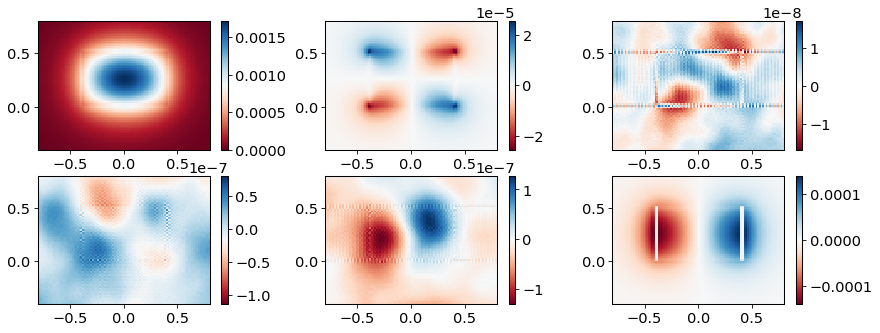

In [510]:
# plot H field gradients back-propagated through group index calculation
        
fig,ax = plt.subplots(2,3,figsize=figsize)


######### method 1  #########

p00 = ax[0,0].pcolormesh(x,
                   y,
                   gr_H[:,:,0].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p00,ax=ax[0,0])
p01 = ax[0,1].pcolormesh(x,
                   y,
                   gr_H[:,:,1].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p01,ax=ax[0,1])
p02 = ax[0,2].pcolormesh(x,
                   y,
                   gr_H[:,:,2].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p02,ax=ax[0,2])

p10 = ax[1,0].pcolormesh(x,
                   y,
                   gr_H[:,:,0].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p10,ax=ax[1,0])
p11 = ax[1,1].pcolormesh(x,
                   y,
                   gr_H[:,:,1].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p11,ax=ax[1,1])
p12 = ax[1,2].pcolormesh(x,
                   y,
                   gr_H[:,:,2].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p12,ax=ax[1,2])



for aa in ax.flatten():
    aa.set_xlim(xlim)
    aa.set_ylim(ylim)
    aa.set_aspect('equal')

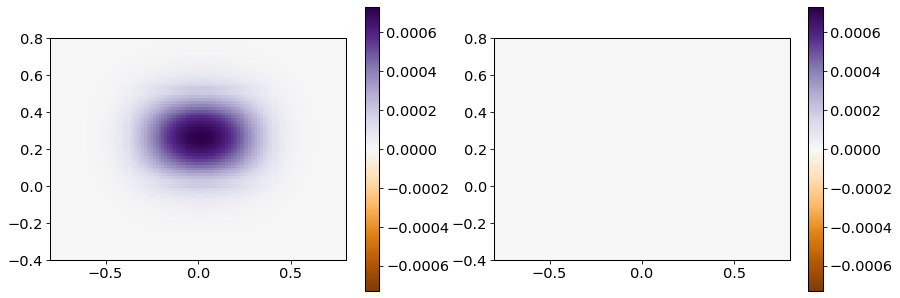

In [511]:
# plot ε gradients back-propagated through group index calculation
        
fig,ax = plt.subplots(1,2,figsize=figsize)
cmap = cm.PuOr

######### method 1  #########

gr_eps_mag_max = np.max(np.abs(gr_eps.real))

p00 = ax[0].pcolormesh(x,
                   y,
                   gr_eps[:,:].real.T,
                   vmin=-gr_eps_mag_max,
                   vmax=gr_eps_mag_max,
                   cmap=cmap,
                  )
plt.colorbar(p00,ax=ax[0])
p01 = ax[1].pcolormesh(x,
                   y,
                   gr_eps[:,:].imag.T,
                    vmin=-gr_eps_mag_max,
                   vmax=gr_eps_mag_max,
                   cmap=cmap,
                  )
plt.colorbar(p01,ax=ax[1])


for aa in ax.flatten():
    aa.set_xlim(xlim)
    aa.set_ylim(ylim)
    aa.set_aspect('equal')

## backprop field gradients through eigensolve

In [514]:
mind = 0
gr_H, gr_ω, gr_eps = grad_ng(H[:,:,0,:,mind],ω[mind],eps,opt.x,opt.y,kz,a=a)

gr_eps_eigs = np.zeros(eps.shape + (3,),dtype='complex128')
for j in range(opt.n_modes):
    if j==mind:
        gr_eps_eigs += np.abs(E[:,:,0,:,j])**2 * ( 2 * gr_ω )
    else:
        scale = np.sum(np.conjugate(H[:,:,0,:,j])*gr_H) / ( ω[j]**2 - ω[mind]**2 ) * dx * dy
        gr_eps_eigs += (np.conjugate(E[:,:,0,:,j]) * E[:,:,0,:,mind] ) * scale
        

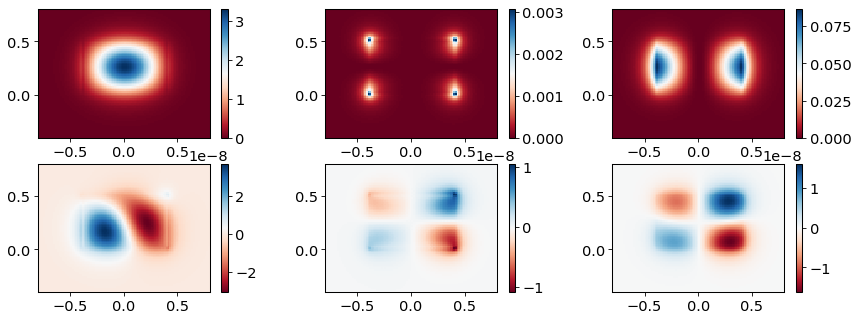

In [515]:
# plot epsilon gradients back- pro through eigensolve
        
fig,ax = plt.subplots(2,3,figsize=figsize)

F = gr_eps_eigs
######### method 1  #########

p00 = ax[0,0].pcolormesh(x,
                   y,
                   F[:,:,0].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p00,ax=ax[0,0])
p01 = ax[0,1].pcolormesh(x,
                   y,
                   F[:,:,1].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p01,ax=ax[0,1])
p02 = ax[0,2].pcolormesh(x,
                   y,
                   F[:,:,2].real.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p02,ax=ax[0,2])

p10 = ax[1,0].pcolormesh(x,
                   y,
                   F[:,:,0].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p10,ax=ax[1,0])
p11 = ax[1,1].pcolormesh(x,
                   y,
                   F[:,:,1].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p11,ax=ax[1,1])
p12 = ax[1,2].pcolormesh(x,
                   y,
                   F[:,:,2].imag.T,
#                    vmin=vmin,
#                    vmax=vmax,
                   cmap=cm.RdBu,
                  )
plt.colorbar(p12,ax=ax[1,2])


for aa in ax.flatten():
    aa.set_xlim(xlim)
    aa.set_ylim(ylim)
    aa.set_aspect('equal')

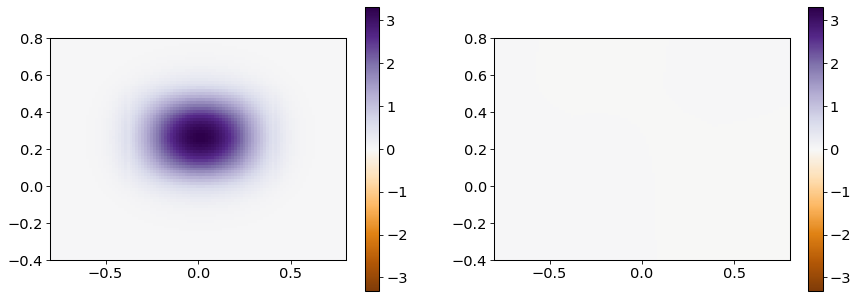

In [517]:
fig,ax = plt.subplots(1,2,figsize=figsize)
cmap = cm.PuOr

F = gr_eps_eigs.sum(axis=2)
F_mag_max = np.max(np.abs(F.real))

p00 = ax[0].pcolormesh(x,
                   y,
                   F[:,:].real.T,
                   vmin=-F_mag_max,
                   vmax=F_mag_max,
                   cmap=cmap,
                  )
plt.colorbar(p00,ax=ax[0])
p01 = ax[1].pcolormesh(x,
                   y,
                   F[:,:].imag.T,
                    vmin=-F_mag_max,
                   vmax=F_mag_max,
                   cmap=cmap,
                  )
plt.colorbar(p01,ax=ax[1])


for aa in ax.flatten():
    aa.set_xlim(xlim)
    aa.set_ylim(ylim)
    aa.set_aspect('equal')

## old

In [214]:
from numpy import fft

fft_func = fft.ifft2
ifft_func = fft.fft2
shift_func = fft.ifftshift
ishift_func = fft.ifftshift
order = 'C'

Hf0 = fft_func(H[:,:,0,0])
Hf1 = fft_func(H[:,:,0,1])

Hf0m = abs(Hf0).max()
Hf1m = abs(Hf1).max()

v2D0 = abs(vecs[:,0,0].reshape((nx,ny),order=order))
v2D1 = abs(vecs[:,1,0].reshape((nx,ny),order=order))

v2D0m = v2D0.max()
v2D1m = v2D1.max()

kx = shift_func(fft.fftfreq(nx,Xgrid/res))
ky = shift_func(fft.fftfreq(ny,Ygrid/res))
Gx = np.arange(-nx/2 + 1,nx/2) * ( (2 *np.pi) / Xgrid )
Gy = np.arange(-ny/2 + 1,ny/2) * ( (2 *np.pi) / Ygrid )

(-1.0, 60.0)

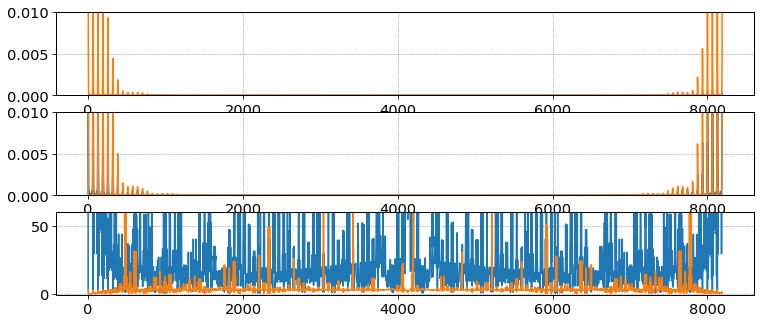

In [200]:
# compare magnitudes of flattened vectors
ylim_ratio = -1,60
ylim_abs = 0.,0.01

fig,ax = plt.subplots(3,1,figsize=(12,5))

ax[0].plot(abs(Hf0).flatten())
ax[0].plot(abs(Hf1).flatten())
ax[0].set_ylim(ylim_abs)
ax[1].plot(abs(vecs[:,0,0]))
ax[1].plot(abs(vecs[:,1,0]))
ax[1].set_ylim(ylim_abs)
ax[2].plot(abs(vecs[:,0,0])/abs(Hf0.flatten()))
ax[2].plot(abs(vecs[:,1,0])/abs(Hf1.flatten()))

ax[2].set_ylim(ylim_ratio)

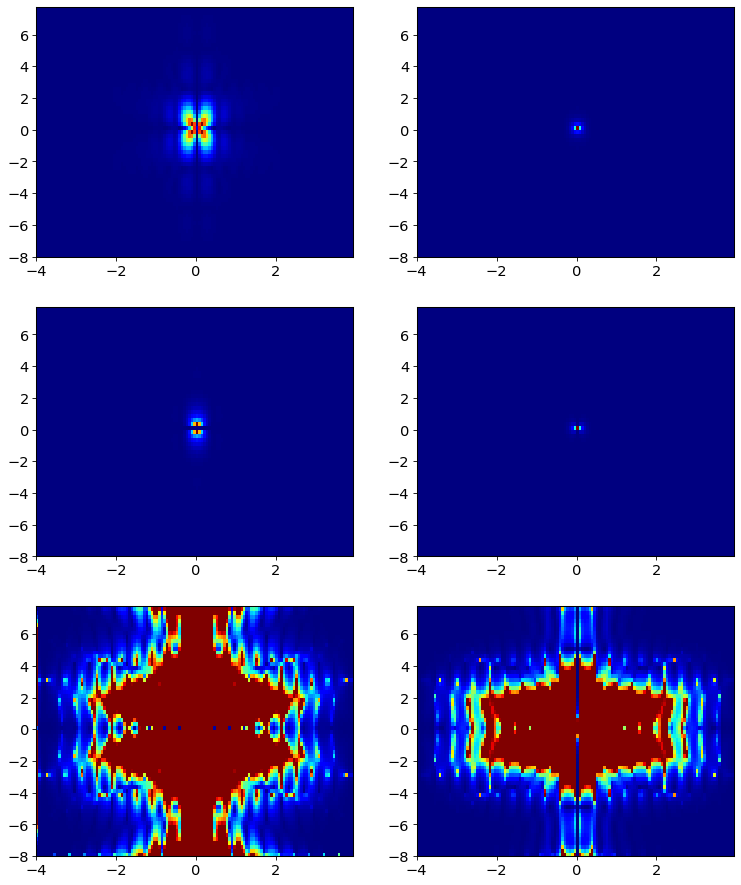

In [199]:
# compare magnitudes of 2D k-space vector fields 

fig,ax = plt.subplots(3,2,figsize=(12,15))

vmax=60
cmap = cm.jet

ax[0,0].pcolormesh(kx,ky,shift_func(abs(Hf0)).T/Hf0m,cmap = cmap)
ax[0,1].pcolormesh(kx,ky,shift_func(abs(Hf1)).T/Hf1m,cmap = cmap)


ax[1,0].pcolormesh(kx,ky,shift_func(v2D0).T/v2D0m,cmap = cmap)
ax[1,1].pcolormesh(kx,ky,shift_func(v2D1).T/v2D1m,cmap = cmap)

ax[2,0].pcolormesh(kx,ky,shift_func(v2D0).T/abs(Hf0).T,cmap = cmap,vmin=0,vmax= vmax)
ax[2,1].pcolormesh(kx,ky,shift_func(v2D1).T/abs(Hf1).T,cmap = cmap,vmin=0,vmax=vmax)


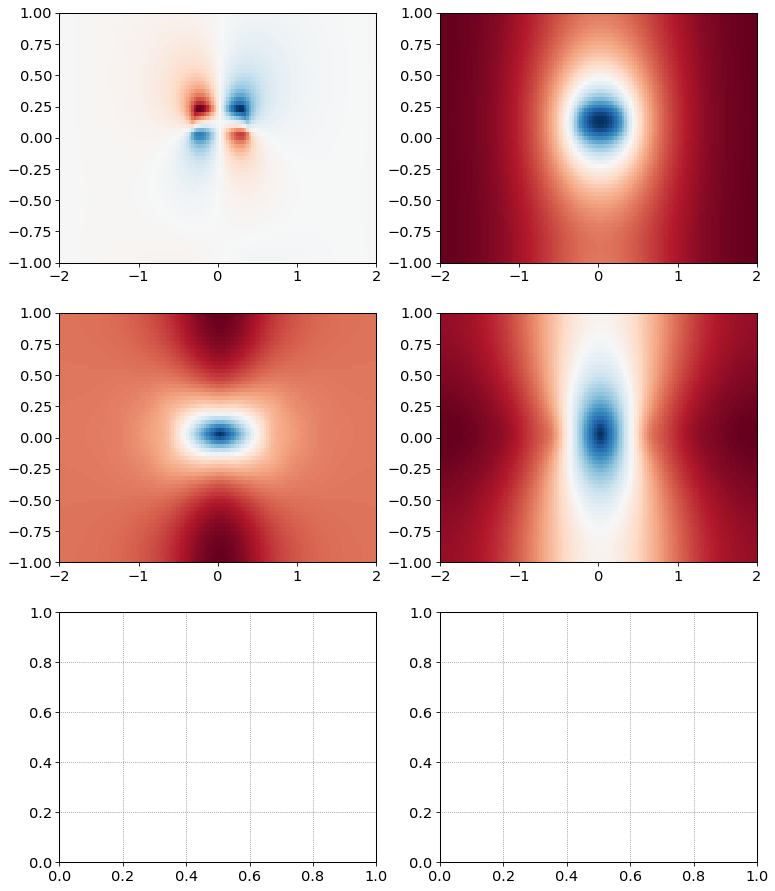

In [223]:
# compare magnitudes of 2D r-space vector fields 

fig,ax = plt.subplots(3,2,figsize=(12,15))

vmax=60
cmap = cm.RdBu

ax[0,0].pcolormesh(x,y,np.real(H_norm[:,:,0,0]).T,cmap = cmap)
ax[0,1].pcolormesh(x,y,np.real(H_norm[:,:,0,1]).T,cmap = cmap)

v2Df0 = ishift_func(fft_func(v2D0)).T
v2Df1 = ishift_func(fft_func(v2D1)).T

# v2Df0 = ifft_func(shift_func(v2D0)).T
# v2Df1 = ifft_func(shift_func(v2D1)).T

v2Df0m = v2Df0.flatten()[np.argmax(np.abs(v2Df0))]
v2Df1m = v2Df1.flatten()[np.argmax(np.abs(v2Df1))]

v2Df0 = v2Df0 / v2Df0m
v2Df1 = v2Df1 / v2Df1m

ax[1,0].pcolormesh(x,y,v2Df0.real,cmap = cmap)
ax[1,1].pcolormesh(x,y,v2Df1.real,cmap = cmap)

# ax[1,0].pcolormesh(kx,ky,shift_func(v2D0).T/v2D0m,cmap = cmap)
# ax[1,1].pcolormesh(kx,ky,shift_func(v2D1).T/v2D1m,cmap = cmap)

# ax[2,0].pcolormesh(kx,ky,shift_func(v2D0).T/abs(Hf0).T,cmap = cmap,vmin=0,vmax= vmax)
# ax[2,1].pcolormesh(kx,ky,shift_func(v2D1).T/abs(Hf1).T,cmap = cmap,vmin=0,vmax=vmax)

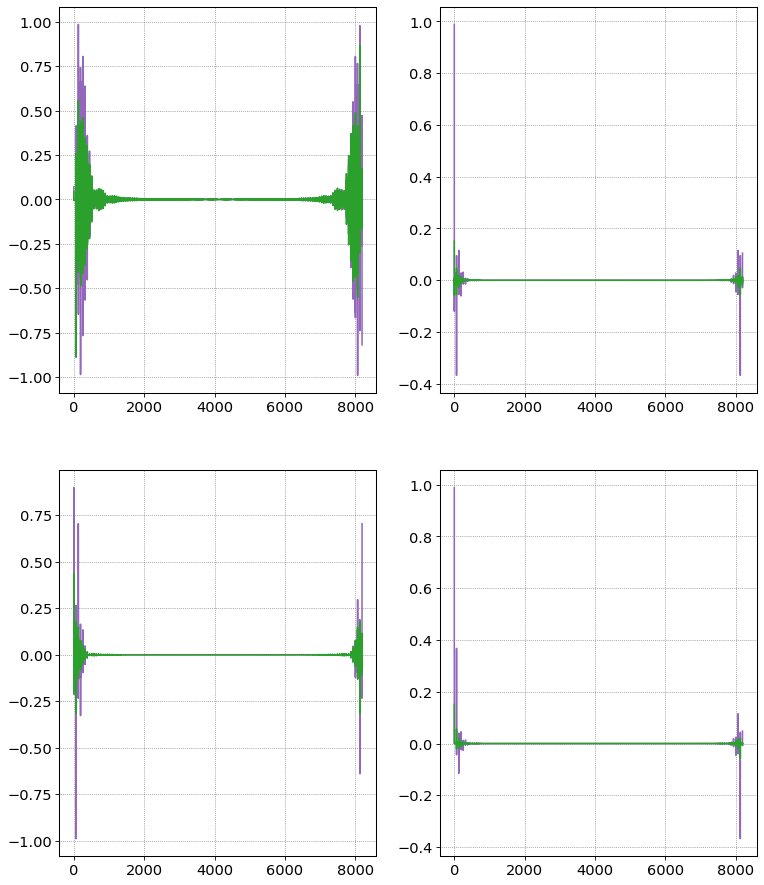

In [172]:
# compare real and imaginary parts of flattened vector components

fig,ax = plt.subplots(2,2,figsize=(12,15))

vmax=60
cmap = cm.jet

ax[0,0].plot(Hf0.flatten().real/Hf0m,color='C4')
ax[0,1].plot(Hf1.flatten().real/Hf1m,color='C4')
ax[0,0].plot(Hf0.flatten().imag/Hf0m,color='C2')
ax[0,1].plot(Hf1.flatten().imag/Hf1m,color='C2')


ax[1,0].plot(vecs[:,0,0].real/v2D0m,color='C4')
ax[1,1].plot(vecs[:,1,0].real/v2D1m,color='C4')
ax[1,0].plot(vecs[:,0,0].imag/v2D0m,color='C2')
ax[1,1].plot(vecs[:,1,0].imag/v2D1m,color='C2')

# ax[2,0].imshow(v2D0/Hf0,cmap = cmap,vmin=0,vmax= vmax)
# ax[2,1].imshow(v2D1/Hf1,cmap = cmap,vmin=0,vmax=vmax)

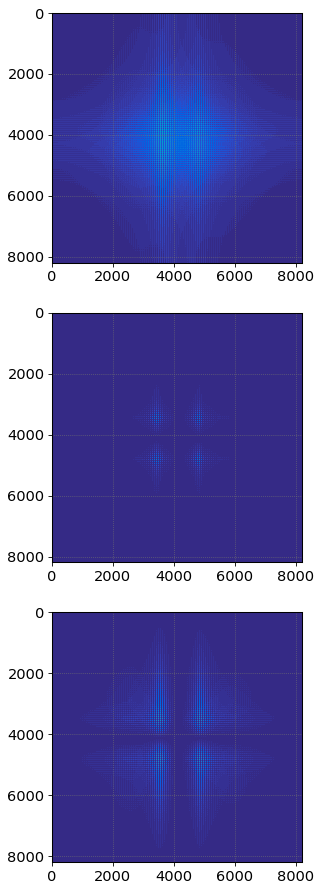

In [245]:

#D.shape # (128, 64, 1, 3)
# op = [np.outer(D[:,:,0,aind].flatten(),D[:,:,0,aind].flatten()) for aind in range(3)]

# aind = 0

fig,ax = plt.subplots(3,1,figsize=(14,15))

for aind in range(3):
    op = np.outer(np.conjugate(D[:,:,0,aind].flatten()),D[:,:,0,aind].flatten())
    ax[aind].imshow(np.abs(op))
    ax[aind].set_aspect('equal')

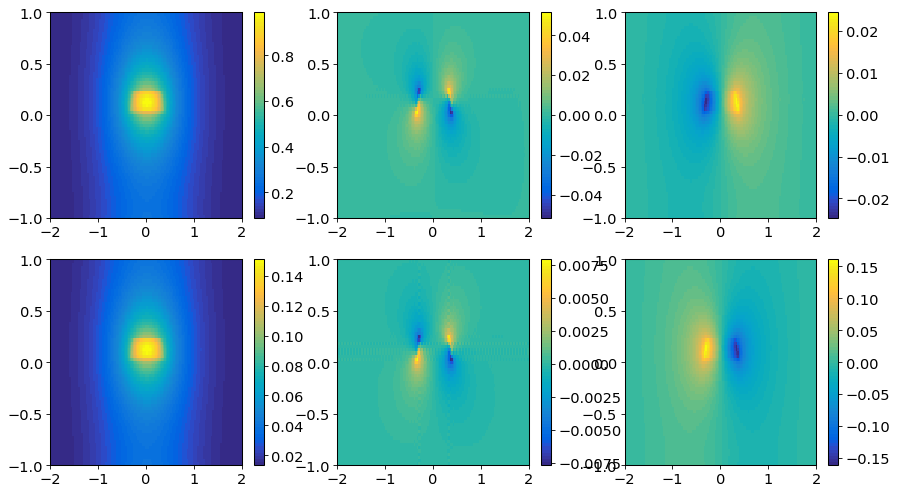

In [240]:
mind = 0

fig,ax = plt.subplots(2,3,figsize=(14,8))

vmax=60
cmap = cm.RdBu

Di_max = D.imag.max()
Dr_max = D.real.max()
Dm_max = np.abs(D).max()

pr0 = ax[0,0].pcolormesh(x,y,D[:,:,mind,0].T.real/Dm_max); plt.colorbar(pr0,ax=ax[0,0])
pr1 = ax[0,1].pcolormesh(x,y,D[:,:,mind,1].T.real/Dm_max); plt.colorbar(pr1,ax=ax[0,1])
pr2 = ax[0,2].pcolormesh(x,y,D[:,:,mind,2].T.real/Dm_max); plt.colorbar(pr2,ax=ax[0,2])

pi0 = ax[1,0].pcolormesh(x,y,D[:,:,mind,0].T.imag/Dm_max); plt.colorbar(pi0,ax=ax[1,0])
pi1 = ax[1,1].pcolormesh(x,y,D[:,:,mind,1].T.imag/Dm_max); plt.colorbar(pi1,ax=ax[1,1])
pi2 = ax[1,2].pcolormesh(x,y,D[:,:,mind,2].T.imag/Dm_max); plt.colorbar(pi2,ax=ax[1,2])



In [250]:
ϵinv = np.zeros((nx,ny,3,3),dtype='complex')
for xind in range(nx):
    for yind in range(ny):
        ϵinv[xind,yind,:,:] = np.array(ms.get_epsilon_inverse_tensor_point(mp.Vector3(x[xind],y[yind],0.)))

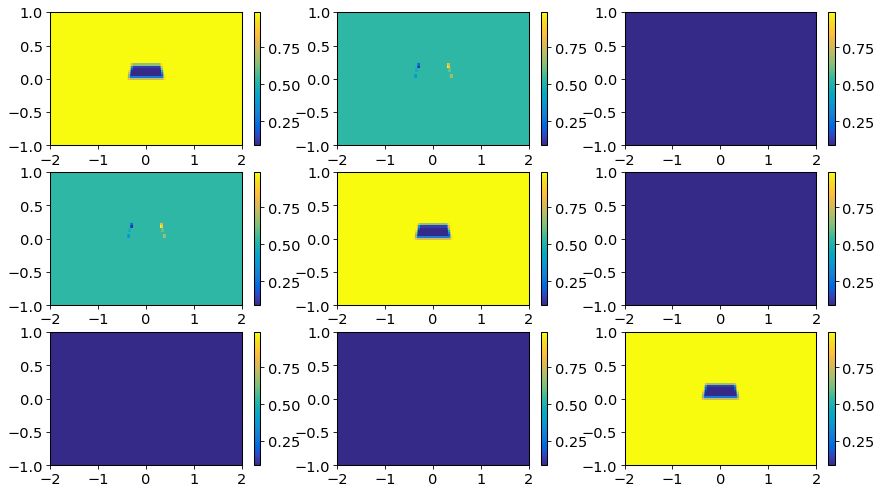

In [251]:
mind = 0

fig,ax = plt.subplots(3,3,figsize=(14,8))

vmax=60
cmap = cm.RdBu


for xind in range(3):
    for yind in range(3):
        p = ax[xind,yind].pcolormesh(x,y,ϵinv[:,:,xind,yind].T.real); plt.colorbar(pr0,ax=ax[xind,yind])


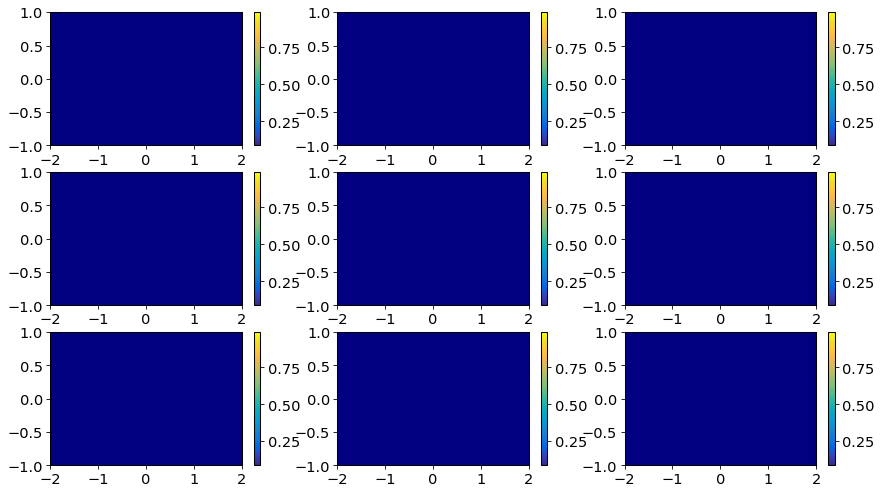

In [253]:
mind = 0

fig,ax = plt.subplots(3,3,figsize=(14,8))

vmax=60
cmap = cm.jet


for xind in range(3):
    for yind in range(3):
        p = ax[xind,yind].pcolormesh(x,y,ϵinv[:,:,xind,yind].T.imag,cmap=cmap)
        plt.colorbar(pr0,ax=ax[xind,yind])